In [1]:
import os
if "COLAB_" in "".join(os.environ.keys()):
	!pip install datasets==3.5.1
	!pip install latex2sympy2-extended
	!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [2]:
from datasets import load_dataset
from functools import lru_cache
from latex2sympy2_extended import latex2sympy
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, f1_score, silhouette_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sympy import Basic
from sympy.parsing.latex import parse_latex
from transformers import AutoTokenizer, AutoModel
from typing import List, Tuple
import logging
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import random
import re
import sympy
import sympy as sp
import torch
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import textstat
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from lightgbm import LGBMRegressor
from scipy.special import softmax
from sklearn.preprocessing import FunctionTransformer
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
import shap
import scipy.sparse as spa



In [3]:
# Set random seed for reproducibility
seed = 42

# Python's built-in random module
random.seed(seed)

# NumPy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Optional: Reduce verbosity

# Scikit-learn
# No explicit seed setting, but you can pass `random_state=seed` to functions like train_test_split, StratifiedKFold, etc.

# Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)  # Optional: Consistent colors

In [4]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("zwhe99/DeepMath-103K", num_proc=4)
train_ds = pd.DataFrame(ds['train'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.22k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/103110 [00:00<?, ? examples/s]

In [5]:
NUM_SAMPLES = 80000

In [6]:
random_indices = random.sample(range(len(train_ds['question'])), NUM_SAMPLES if NUM_SAMPLES != float('inf') else len(train_ds['question']))

In [7]:
train_ds_qs = train_ds['question']
train_ds_tp = train_ds['topic']
train_ds_diff = train_ds['difficulty']
reason_1_ds = train_ds['r1_solution_1']
reason_2_ds = train_ds['r1_solution_2']
reason_3_ds = train_ds['r1_solution_3']
answer = train_ds['final_answer']

In [8]:
train_ds_qs = train_ds_qs[random_indices]
train_ds_tp = train_ds_tp[random_indices]
reason_1_ds = reason_1_ds[random_indices]
reason_2_ds = reason_2_ds[random_indices]
reason_3_ds = reason_3_ds[random_indices]

# Preliminary tasks

## Briefly describe the data

In [ ]:
print("Number of samples:", train_ds.num_rows)
print("Number of topics:", len(set(train_ds_tp)))
print("Number of different difficulties:", len(set(train_ds_diff)))

Number of samples: 103110
Number of topics: 82
Number of different difficulties: 20


In [ ]:
label_counts = Counter(train_ds_tp)
label_counts

Counter({'Mathematics -> Precalculus -> Limits': 7409,
         'Mathematics -> Differential Equations -> Ordinary Differential Equations (ODEs)': 1044,
         'Mathematics -> Applied Mathematics -> Statistics -> Probability -> Counting Methods -> Combinations': 1313,
         'Mathematics -> Calculus -> Integral Calculus -> Applications of Integrals': 4747,
         'Mathematics -> Algebra -> Intermediate Algebra -> Other': 2958,
         'Mathematics -> Geometry -> Plane Geometry -> Polygons': 1114,
         'Mathematics -> Algebra -> Intermediate Algebra -> Exponential Functions': 1861,
         'Mathematics -> Applied Mathematics -> Statistics -> Probability -> Other': 4269,
         'Mathematics -> Algebra -> Algebra -> Polynomial Operations': 3000,
         'Mathematics -> Algebra -> Abstract Algebra -> Field Theory': 2778,
         'Mathematics -> Algebra -> Linear Algebra -> Linear Transformations': 1379,
         'Mathematics -> Differential Equations -> Partial Differential

In [ ]:
labels = pd.Series(train_ds_tp)
general_labels = labels.str.split("->").str[1].str.strip()
general_labels.value_counts()

Algebra                   32800
Calculus                  28283
Precalculus                9033
Geometry                   8426
Applied Mathematics        7846
Number Theory              5843
Discrete Mathematics       5820
Other                      3483
Differential Equations     1576
Name: count, dtype: int64

In [ ]:
counts=Counter(train_ds_diff)
sorted_by_key = sorted(counts.items(), key=lambda x: x[0])
for k, v in sorted_by_key:
    print(f"{k}: {v}")

-1.0: 4
1.0: 15
1.5: 39
2.0: 123
2.5: 146
3.0: 3142
3.5: 990
4.0: 5466
4.5: 4391
5.0: 16358
5.5: 14806
6.0: 17488
6.5: 7750
7.0: 8561
7.5: 6746
8.0: 11686
8.5: 3989
9.0: 1356
9.5: 51
10.0: 3


## Parsing

### Initial investigation on sympy

In [ ]:

def extract_latex_bracket_content(text):
    patterns = [
        r'\\\[(.*?)\\\]',  # \[ ... \]
        r'\\\((.*?)\\\)',  # \( ... \)
        r'\$(.*?)\$',       # $ ... $
    ]
    # Combine patterns into one
    combined_pattern = '|'.join(patterns)
    #matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    #formulas = [next(filter(None, tup)) for tup in matches]
    matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    formulas = []
    for tup in matches:
        non_empty = list(filter(None, tup))
        if non_empty:
            formulas.append(non_empty[0])
    # Use a counter to number the placeholders
    def replacer(match, counter=[1]):
        placeholder = "{" + str(counter[0]-1) + "}"
        counter[0] += 1
        return placeholder
    new_text = re.sub(combined_pattern, replacer, text)
    return new_text, formulas

parsed_indices = []
parsed_text = []
parsed_formulas = []
for i in range(len(train_ds_qs)):
    d = train_ds_qs[i]
    #print("original input:", d)
    text, formulas = extract_latex_bracket_content(d)
    #print("parsed text: ", text, "\nequations: ", formulas)
    formulas_sympy = []
    num_parsed = 0
    for expr in formulas:
        try:
            parsed = parse_latex(expr)
            formulas_sympy.append(parsed)
            num_parsed += 1
        except Exception as e:
            pass
            #print("Could not parse:", e)
            #print(parsed)
    if num_parsed == len(formulas):
        parsed_indices.append(i)
        parsed_text.append(text)
        parsed_formulas.append(formulas_sympy)
print("correctly parsed", len(parsed_indices), "inputs over", len(train_ds_qs))

### Tokenizers

This module provides utilities for normalizing and parsing mathematical expressions in LaTeX format, enabling accurate comparison and evaluation in NLP tasks involving math reasoning. 

It handles:
- expression cleaning
- mixed number normalization
- LaTeX-to-SymPy conversion
- expression tree tokenization. 

Portions of the logic are adapted from open-source projects as reported.

In [ ]:
# Copyright (c) 2024, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Copyright (c) Microsoft Corporation.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE

# Copyright (c) 2023 OpenAI
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Copyright (c) 2021 Dan Hendrycks
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


"""
This logic is largely copied from the Hendrycks' MATH release (math_equivalence), and borrowed from:
- https://github.com/microsoft/ToRA/blob/main/src/eval/grader.py
- https://github.com/microsoft/ProphetNet/tree/master/CRITIC
- https://github.com/openai/prm800k
"""


import re

def _remove_left_and_right(expr):
    """Remove the right and left latex commands."""
    expr = re.sub(r"\\left", "", expr)
    expr = re.sub(r"\\right", "", expr)
    return expr

def _process_and_or_inside_text(string):
    string = re.sub(r"\s*\\text{\s*(or|and)\s*}\s*", ",", string)
    string = re.sub(r",\s*,", ",", string)
    return string

def _inject_implicit_mixed_number(step: str):
    """
    Automatically make a mixed number evalable
    e.g. 7 3/4 => 7+3/4
    """
    p1 = re.compile("([0-9]) +([0-9])")
    step = p1.sub("\\1+\\2", step)  ## implicit mults
    return step

def _remove_right_units(expr):
    # "\\text{ " only ever occurs (at least in the val set) when describing units
    if "\\text" in expr:
        try:
            splits = re.split(r"\\text\s*{\s*", expr)
            # print(splits)
            assert len(splits) == 2 and splits[0] not in ("", "(")
            return splits[0]
        except AssertionError:
            pass

    if "\\text{" in expr:
        return re.sub(r"\\text{([^}]+)}", r"\1", expr)
    elif "\\mbox{" in expr:
        splits = expr.split("\\mbox{")
        if len(splits) == 2:
            return splits[0]
        else:
            return expr
    else:
        return expr

def _fix_interval(expr):
    """Fix interval expression."""
    if "\\in " in expr:
        return expr.split("\\in ")[1].strip()

    return expr

def _fix_sqrt(string):
    _string = re.sub(r"\\sqrt(\s*\w+)", r"\\sqrt{\1}", string)
    return _string

def _fix_fracs(string):
    # replacing all extra spaces
    while "\\frac " in string:
        string = string.replace("\\frac ", "\\frac")
    substrs = string.split("\\frac")
    new_str = substrs[0]
    if len(substrs) > 1:
        substrs = substrs[1:]
        for substr in substrs:
            new_str += "\\frac"
            if len(substr) > 0 and substr[0] == "{":
                new_str += substr
            else:
                try:
                    assert len(substr) >= 2
                except:
                    return string
                a = substr[0]
                b = substr[1]
                if b != "{":
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}{" + b + "}" + post_substr
                    else:
                        new_str += "{" + a + "}{" + b + "}"
                else:
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}" + b + post_substr
                    else:
                        new_str += "{" + a + "}" + b
    string = new_str
    return string

def _inject_implicit_mixed_fraction(step: str):
    """
    Automatically make a mixed number evalable
    e.g. 7 \\frac{3}{4} => 7+3/4
    """
    p1 = re.compile(r"(\d+) *\\frac{(\d+)}{(\d+)}")

    def replacer(match):
        whole_part = match.group(1)
        numerator = match.group(2)
        denominator = match.group(3)

        if whole_part:
            return f"{whole_part} + {numerator}/{denominator}"
        else:
            return f"{numerator}/{denominator}"

    step = p1.sub(replacer, step)
    return step

def _strip_properly_formatted_commas(expr: str):
    # We want to be careful because we don't want to strip tuple commas
    p1 = re.compile(r"(\d)(,)(\d\d\d)($|\D)")
    while True:
        next_expr = p1.sub("\\1\\3\\4", expr)
        if next_expr == expr:
            break
        expr = next_expr
    return next_expr

def _str_is_int(x: str) -> bool:
    try:
        x = _strip_properly_formatted_commas(x)
        x = float(x)
        return abs(x - int(round(x))) <= 1e-7
    except:
        return False

def _str_to_int(x: str) -> bool:
    x = x.replace(",", "")
    if "_" in x:
        # Due to base
        x = x.split("_")[0]
    x = float(x)
    return int(x)

def normalize(answer) -> str:
    # checking if answer is $<number> and removing $ in that case to compare
    if isinstance(answer, str) and bool(re.match(r'\$\d+(\.\d+)?', answer)):
        return answer[1:]

    # checking if answer is <number>% or <number>\\% and removing %
    if isinstance(answer, str) and (
        bool(re.match(r'^\d+(\.\d+)?%$', answer)) or bool(re.match(r'^\d+(\.\d+)?\\%$', answer))
    ):
        return answer.replace("\\%", "").replace("%", "")

    return answer

def normalize_answer_string(expr: str, apply_other_normalize_first: bool = True) -> str:
    if apply_other_normalize_first:
        expr = normalize(expr)
    """Normalize answer expressions."""
    if expr is None:
        return None

    # Remove enclosing `\text{}`.

    expr = _remove_left_and_right(expr)
    expr = _process_and_or_inside_text(expr)
    expr = _remove_right_units(expr)
    expr = _fix_interval(expr)
    for surround_str in ["\\\\text", "\\\\mathrm", "\\\\mathcal", "\\\\textbf", "\\\\textit"]:
        expr = expr.replace(surround_str, "")
        pattern = f"^{surround_str}" + r"\{(?P<text>.+?)\}$"
        m = re.search(pattern, expr)
        if m is not None:
            expr = m.group("text")

    expr = expr.replace(r"\!", "")
    expr = expr.replace("\\%", "%")
    expr = expr.replace("\\$", "$")
    expr = expr.replace("$", "")
    expr = expr.replace("%", "")
    expr = expr.replace("^{\\circ}", "")

    expr = expr.replace(" or ", " , ")
    expr = expr.replace(" and ", " , ")

    expr = expr.replace("million", "*10^6")
    expr = expr.replace("billion", "*10^9")
    expr = expr.replace("trillion", "*10^12")

    for unit in [
        "degree",
        "cm",
        "centimeter",
        "meter",
        "mile",
        "second",
        "minute",
        "hour",
        "week",
        "month",
        "year",
        "foot",
        "feet",
        "inch",
        "yard",
        "p.m.",
        "PM",
    ]:
        expr = re.sub(rf"{unit}(es)?(s)? *(\^[0-9]+)?", "", expr)

    if "day" in expr:
        days = [
            "Monday",
            "Tuesday",
            "Wednesday",
            "Thursday",
            "Friday",
            "Saturday",
            "Sunday",
        ]
        weekday_expressed = False
        for day in days:
            if day in expr:
                weekday_expressed = True
                break

        if not weekday_expressed:
            expr = re.sub(f"day(s)?", "", expr)

    expr = re.sub(rf"\^ *\\\\circ", "", expr)

    if len(expr) > 0 and expr[0] == "{" and expr[-1] == "}":
        expr = expr[1:-1]

    expr = _fix_sqrt(expr)

    # \frac1b or \frac12 --> \frac{1}{b} and \frac{1}{2}, etc. Even works with \frac1{72} (but not \frac{72}1). Also does a/b --> \\frac{a}{b}
    expr = _fix_fracs(expr)

    # edge case with mixed numbers and negative signs
    expr = re.sub("- *", "-", expr)
    expr = _inject_implicit_mixed_number(expr)
    expr = _inject_implicit_mixed_fraction(expr)
    expr = expr.replace(" ", "")

    if _str_is_int(expr):
        expr = str(_str_to_int(expr))

    return expr


In [ ]:
class BaseStrat:
    def __init__(self):
        pass

    def run(self) -> Tuple[bool, List[str]]:
        pass

# These are used to normalize answers from the official repository, we try to normalize questions too
#from utils.math_utils import normalize_answer_string
class ComplexFilterStrat(BaseStrat):
    def __init__(self):
        self.rgx = re.compile(
            r"\$\$(.*?)\$\$"
            r"|\\\[(.*?)\\\]"
            r"|\\\((.*?)\\\)"
            r"|\$(.*?)\$"
            r"|\\begin\{(equation\*?|align\*?|multline)\}(.*?)\\end\{\1\}",
            re.DOTALL
        )

    def extract_latex_expressions(self,text):
        math_exprs = []
        def _repl(m):
            expr = next(g for g in m.groups() if g is not None)
            idx = len(math_exprs)
            math_exprs.append(expr)
            return f"[[MATH{idx}]]"

        cleaned = self.rgx.sub(_repl, text)
        return cleaned, math_exprs

    def parse_mixed_latex(self, text: str, eval_math: bool = True):
        cleaned, math_exprs = self.extract_latex_expressions(text)
        normalized = [normalize_answer_string(expr) for expr in math_exprs]
        parsed_exprs = []

        if eval_math:
            for expr in normalized:
                try:
                    parsed = latex2sympy(expr)
                    parsed_exprs.append(parsed if parsed is not None else expr)
                except Exception as e:
                    #print('latex2sympy failed: ', e)
                    parsed_exprs.append(expr.split())
        else:
            parsed_exprs = [None] * len(normalized)

        # Substitute back into text
        substituted_text = cleaned
        for i, expr in enumerate(parsed_exprs):
            assert expr is not None
            if isinstance(expr, List):
                expr = [str(e) for e in expr]
                display_expr = " ".join(expr)
            else:
                display_expr = str(expr)
            substituted_text = substituted_text.replace(f"[[MATH{i}]", display_expr)

        return {
            "text": cleaned,
            "math_raw": math_exprs,
            "math_normalized": normalized,
            "math_parsed": parsed_exprs,
            "text_with_parsed": substituted_text,
        }

    def run(self, text):
        res = self.parse_mixed_latex(text)
        return False, res['text_with_parsed'].split()

class TreeWalkStrat(BaseStrat):
    def __init__(self):
        pass

    def run(self, text):
        def print_sympy_tree(expr, indent=0):
            print('  ' * indent + str(expr.func))
            for arg in expr.args:
                print_sympy_tree(arg, indent + 1)

        # --- Parse LaTeX into sympy then walk the expression tree ---
        def flatten_sympy_expr(expr: Basic):
            tokens = []

            def walk(node):
                if isinstance(node, Basic):
                    args_len = len(node.args)
                    args = node.args
                    # If only 1 we build the output as operator + walk(operand)
                    if args_len == 1:
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        walk(args[0])
                    # If only 2 we build the output with inorder visit walk(operand0) + operator + walk(operand1)
                    elif args_len == 2:
                        walk(args[0])
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        walk(args[1])
                    # If no operands are found we just add self
                    elif args_len == 0:
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                    # If there are multiple operands (> 2) we add them all after the operator
                    else:
                        if isinstance(node, (sympy.Limit, sympy.Integral)):
                            args = reversed(args)
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        for arg in args:
                            walk(arg)
                else:
                    raise RuntimeError("not sympy Basic object")

            walk(expr)
            return tokens

        # --- Main tokenization function ---
        def tokenize(text):
            math_pattern = r'(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.*?\\\))'
            parts = re.split(math_pattern, text, flags=re.DOTALL)

            final_tokens = []
            is_erorr = False
            for part in parts:
                if re.match(math_pattern, part, flags=re.DOTALL):
                    # Clean math delimiters
                    clean = re.sub(r'^(\$+|\\\[|\\\(|\\])|(\$+|\\\]|\\\))$', '', part.strip())
                    try:
                        parsed = parse_latex(clean)
                        math_tokens = flatten_sympy_expr(parsed)
                        final_tokens.extend(math_tokens)
                    except Exception as e:
                        #is_erorr = True
                        final_tokens.extend(clean.split(' '))
                else:
                    final_tokens.extend(re.findall(r'\b\w+\b', part))
            return is_erorr, final_tokens

        return tokenize(text)

class  HybridMathTokenizerStrat(BaseStrat):
    def __init__(self):
        super().__init__()

    def run(self, text):
        # -----------------------------------------------------------------------------
        #  Regex & cleaning helpers
        # -----------------------------------------------------------------------------
        _MATH_ENV_RE = re.compile(
            r"\$\$(.*?)\$\$"                    # $$...$$
            r"|\\\[(.*?)\\\]"                   # \[...\]
            r"|\\\((.*?)\\\)"                   # \(...\)
            r"|\$(.*?)\$"                           # $...$
            r"|\\begin\{(equation\*?|align\*?|multline)\}(.*?)\\end\{\1\}",
            re.DOTALL,
        )

        _CLEAN_REPLACES = [
            (r"\\displaystyle", ""),
            (r"\\left|\\right", ""),           # sizing commands
            (r"\\[ ,;!]", ""),                 # spacing commands
        ]

        _WORD_RE = re.compile(r"\w+|[^\w\s]", re.UNICODE)


        def clean_latex(latex: str) -> str:
            for pat, rep in _CLEAN_REPLACES:
                latex = re.sub(pat, rep, latex)
            return re.sub(r"\s+", " ", latex).strip()


        def extract_math_spans(text: str) -> Tuple[str, List[str]]:
            spans: List[str] = []
            def _repl(m: re.Match) -> str:
                latex = next(g for g in m.groups() if g is not None)
                idx = len(spans)
                spans.append(latex)
                return f"[[MATH{idx}]]"
            return _MATH_ENV_RE.sub(_repl, text), spans


        def flatten_sympy_expr(expr: sp.Basic) -> List[str]:
            if expr.is_Atom:
                return [str(expr)]
            toks = [expr.func.__name__]
            for arg in expr.args:
                toks.extend(flatten_sympy_expr(arg))
            return toks

        # -----------------------------------------------------------------------------
        #  LaTeX → tokens converter
        # -----------------------------------------------------------------------------
        @lru_cache(maxsize=200_000)
        def tokenize_math(latex: str) -> Tuple[bool, List[str]]:
            latex = clean_latex(latex)
            if len(latex) > 500 or latex.count("{") > 25:
                return False, latex.split()

            try:
                expr = latex2sympy(latex, dummy_symbol_func=lambda n: sp.Symbol(n))
                return False, flatten_sympy_expr(expr)
            except Exception as exc:
                logging.debug("[tokenize_math] fallback on `%s` (%s)", latex, exc)
                # fallback but treat as no error
                return False, latex.split()

        # -----------------------------------------------------------------------------
        #  Plain-text and hybrid tokenizers
        # -----------------------------------------------------------------------------

        def text_tokenize(text: str) -> List[str]:
            return _WORD_RE.findall(text)


        def tokenize(text: str) -> Tuple[bool, List[str]]:
            cleaned, spans = extract_math_spans(text)
            parts = re.split(r"(\[\[MATH\d+\]\])", cleaned)

            tokens: List[str] = []
            had_error = False

            for part in parts:
                m = re.fullmatch(r"\[\[MATH(\d+)\]\]", part)
                if m:
                    idx = int(m.group(1))
                    err, mtoks = tokenize_math(spans[idx])
                    had_error |= err
                    tokens.extend(mtoks)
                    continue

                raw = text_tokenize(part)
                i = 0
                while i < len(raw):
                    if raw[i].startswith("\\"):
                        depth = raw[i].count("{") - raw[i].count("}")
                        j = i + 1
                        while j < len(raw) and depth > 0:
                            depth += raw[j].count("{") - raw[j].count("}")
                            j += 1
                        latex_inline = " ".join(raw[i:j])
                        err, mtoks = tokenize_math(latex_inline)
                        had_error |= err
                        tokens.extend(mtoks)
                        i = j
                    else:
                        tokens.append(raw[i])
                        i += 1
            return had_error, tokens
        return tokenize(text)

class PassThroughStrat(BaseStrat):
    def __init__(self):
        super().__init__()

    def run(self, text):
        return True, [text]

# TODO: add embeddings support
class Tokenizer:
    def __init__(self, strat: str, tokenizer: str = "allenai/longformer-base-4096", remove_numbers: bool = False):
        self.strat_dict = {
            'complex-filter': ComplexFilterStrat,
            'tree-walk': TreeWalkStrat,
            'hybrid-math':  HybridMathTokenizerStrat,
            'pass-through': PassThroughStrat
        }
        self.strat = self.strat_dict[strat]()
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer)
        self.remove_numbers = remove_numbers

    def __call__(self, *args, **kwds):
        parsed = self.parse(*args)
        return self.tokenizer.encode(" ".join(parsed))

    def parse(self, *args, **kwds):
        error, res = self.strat.run(*args)
        if error:
            raise RuntimeError(error)
        res = [r for r in res if r not in [' ', '']]
        if self.remove_numbers:
            res = [r for r in res if not re.match(r'[-+]?(?:\d+\.\d*|\.\d+|\d+)', r)]
        return res


## Perform cluster analysis on questions field

In [11]:
n = 1000  # number of samples per general topic
topic_samples = defaultdict(list)

# Stream through the dataset
for idx, row in train_ds.iterrows():
    full_topic = row['topic']
    try:
        general_topic = full_topic.split("->")[1].strip()
    except IndexError:
        continue  # skip malformed labels

    if len(topic_samples[general_topic]) < n:
        topic_samples[general_topic].append(row)

# Flatten samples
flat_rows = [item for sublist in topic_samples.values() for item in sublist]

# Extract questions and their general topics
train_clust = pd.Series([row['question'] for row in flat_rows])
labels_clust = pd.Series([row['topic'].split("->")[1].strip() for row in flat_rows])

print(train_clust.shape)
print(labels_clust.value_counts())


(9000,)
Precalculus               1000
Differential Equations    1000
Applied Mathematics       1000
Calculus                  1000
Algebra                   1000
Geometry                  1000
Number Theory             1000
Other                     1000
Discrete Mathematics      1000
Name: count, dtype: int64


In [12]:
# Vectorize the text
tokenizer = Tokenizer('hybrid-math', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_hybrid_math = TfidfVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.9, min_df=5, stop_words='english')
X_vec_hybrid_math = vectorizer_hybrid_math.fit_transform(train_clust)

tokenizer = Tokenizer('complex-filter', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_complex_filter = TfidfVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.9, min_df=5, stop_words='english')
import sys
sys.set_int_max_str_digits(20000)
X_vec_complex_filter = vectorizer_complex_filter.fit_transform(train_clust)

X_vecs = [X_vec_hybrid_math, X_vec_complex_filter]
vectorizers = [vectorizer_hybrid_math, vectorizer_complex_filter]

print(X_vec_hybrid_math[0].shape, X_vec_complex_filter[1].shape)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

(1, 2535) (1, 2788)


In [ ]:
for vectorizer in vectorizers:
  vocab = vectorizer.get_feature_names_out()
  print(f"Length of vocabulary: {len(vocab)}")
  vocab[:100]

Length of vocabulary: 2535
Length of vocabulary: 2788


### KMeans

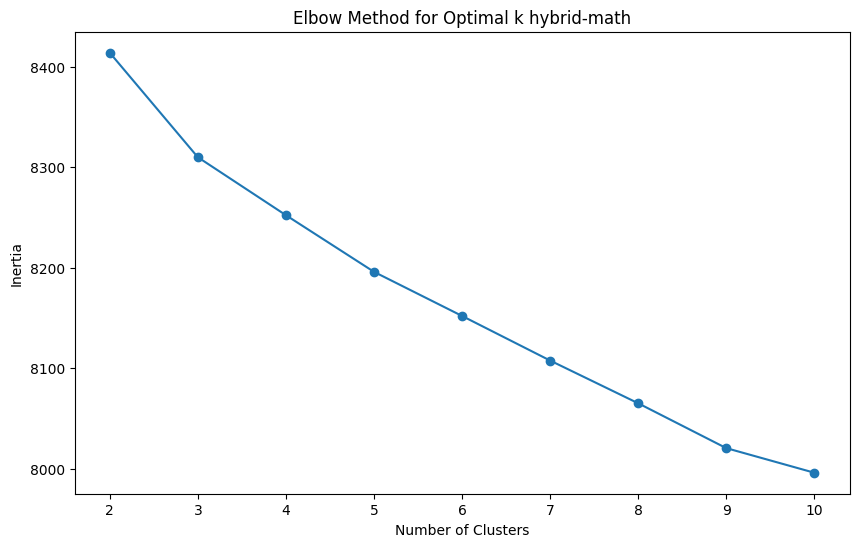

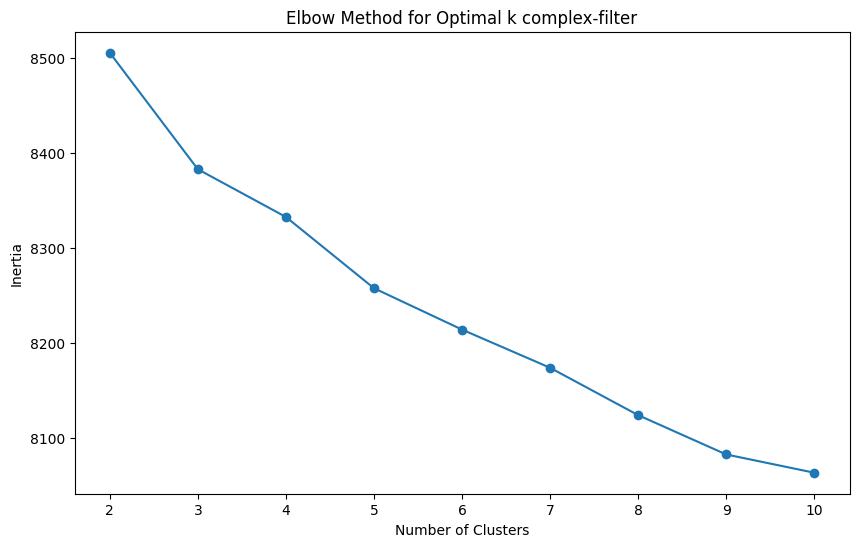

In [ ]:
# 1. Determining the optimal number of clusters (Elbow Method)
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  inertia = []
  range_n_clusters = range(2, 11)

  for n_clusters in range_n_clusters:
      kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=seed)
      kmeans.fit(X_vec)
      inertia.append(kmeans.inertia_)

  plt.figure(figsize=(10, 6))
  plt.plot(range_n_clusters, inertia, marker='o')
  plt.title(f'Elbow Method for Optimal k {name}')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.show()

Optimal number of clusters based on silhouette score: 2


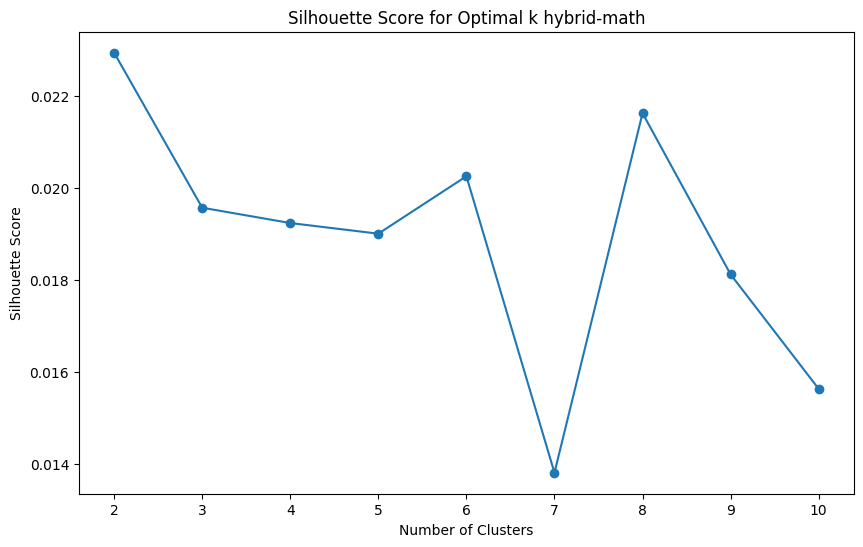

Optimal number of clusters based on silhouette score: 10


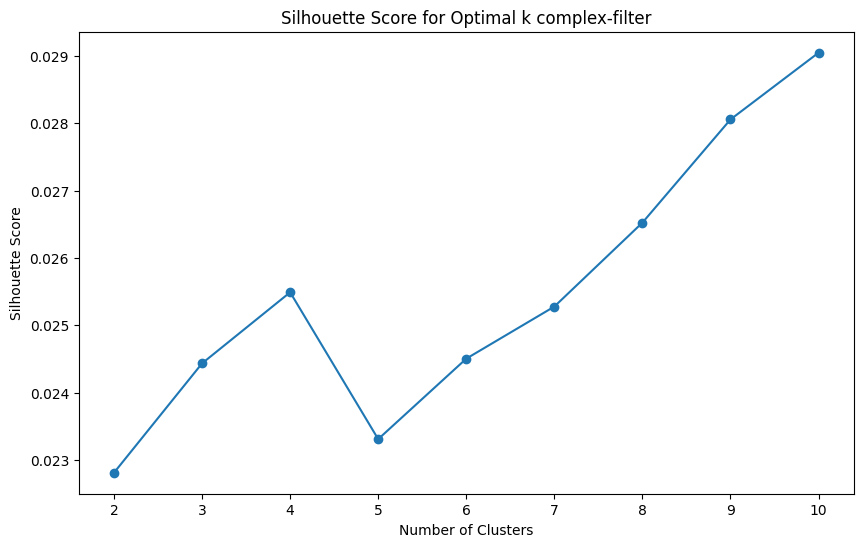

In [ ]:
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  silhouette_scores = []
  range_n_clusters = range(2, 11)

  for n_clusters in range_n_clusters:
      kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=seed)
      cluster_labels = kmeans.fit_predict(X_vec)
      silhouette_avg = silhouette_score(X_vec, cluster_labels)
      silhouette_scores.append(silhouette_avg)

  best_k_silhouette = range_n_clusters[np.argmax(silhouette_scores)]
  print(f"Optimal number of clusters based on silhouette score: {best_k_silhouette}")

  plt.figure(figsize=(10, 6))
  plt.plot(range_n_clusters, silhouette_scores, marker='o')
  plt.title(f'Silhouette Score for Optimal k {name}')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.show()

In [ ]:
n_clusters = [8,10] # from elbow

kmeans = []
cluster_labels = []
for n in n_clusters:
  # 2. Applying the K-Means algorithm
  k = KMeans(n_clusters=n, n_init=10, random_state=seed)
  kmeans.append(k)
  cluster_labels.append(k.fit_predict(X_vec))

In [ ]:
# 3. Investigating the clusters
# first: hybrid-math
# second: complex-filter
for k, v in zip(kmeans, vectorizers):
  print("Top terms per cluster:")
  vocab = vectorizer_complex_filter.get_feature_names_out()

  for i in range(k.n_clusters):
      centroid = k.cluster_centers_[i]
      sorted_terms = centroid.argsort()[::-1]
      print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['determine', 'evaluate', 'integral', '-', 'limit', 'given', 'value', '+', 'function', 'calculate']
Cluster 1:	['limit:', 'oo,', "dir='-')]", 'evaluate', 'x,', '+', 'n,', "dir='+')]", '-', "dir='-')]."]
Cluster 2:	['differential', 'equation', '+', 'solution', 'initial', 'solve', 'condition', '-', 'equation:', 'given']
Cluster 3:	['random', '<', '&', 'calculate', '<=', 'probability', 'variables', 'independent', 'x]', '(0']
Cluster 4:	['+', '-', 'value', 'given', 'equation', 'determine', 'function', 'evaluate', 'x', '<=']
Cluster 5:	['let', 'set', 'space', 'does', 'x]', 'determine', 'answer.', 'f]', 'function', 'provide']
Cluster 6:	['limit:', 'evaluate', 'calculate', 'compute', 'value', 'z,', 'following', "dir='+')]", 'using', 'math{n}]']
Cluster 7:	['number', 'integer', 'n]', 'determine', 'positive', 'digits', 'prime', 'integers', '+', 'numbers']
Top terms per cluster:
Cluster 0:	['oo,', "dir='-')]", 'n,', 'limit:', '+', 'evaluate', 'x,', '-', "dir='-'

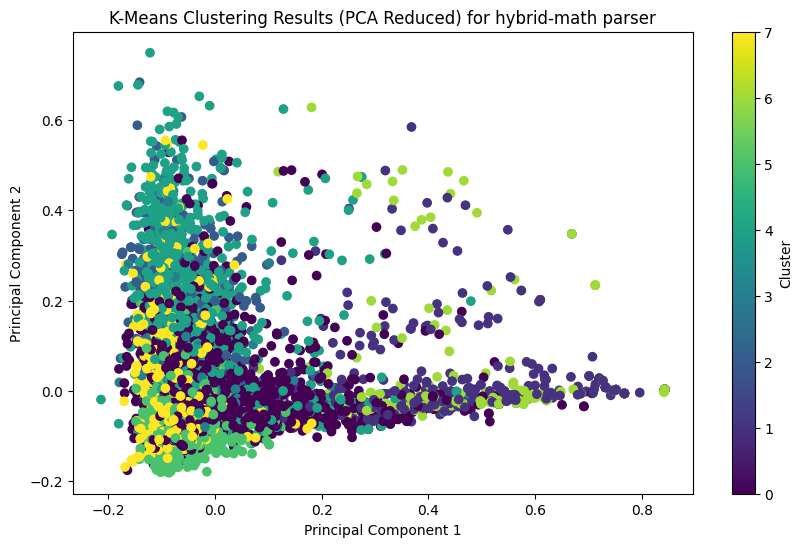

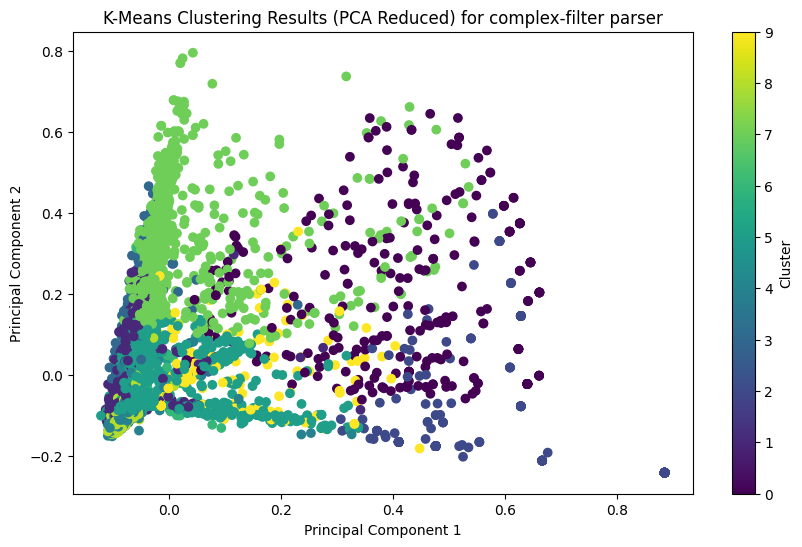

In [ ]:
# 4. Visualizing the clusters (using PCA for dimensionality reduction)
for X_vec, c_labels, name in zip(X_vecs, cluster_labels, ['hybrid-math', 'complex-filter']):
  pca = PCA(n_components=2)
  reduced_features2d = pca.fit_transform(X_vec.toarray())

  plt.figure(figsize=(10, 6))
  scatter = plt.scatter(reduced_features2d[:, 0], reduced_features2d[:, 1], c=c_labels, cmap='viridis')
  plt.title(f'K-Means Clustering Results (PCA Reduced) for {name} parser')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.colorbar(scatter, label='Cluster')
  plt.show()

In [ ]:
import plotly.graph_objects as go
for X_vec, c_labels, name in zip(X_vecs, cluster_labels, ['hybrid-math', 'complex-filter']):
  pca = PCA(n_components=3)
  reduced_features = pca.fit_transform(X_vec.toarray())

  fig = go.Figure(data=[go.Scatter3d(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    z=reduced_features[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=c_labels,          # Cluster or class labels for coloring
        colorscale='Viridis',
        opacity=0.8
    ),
    text=[f"Index: {i}" for i in range(len(c_labels))]  # Optional hover text
  )])

  fig.update_layout(
      title=f'PCA for {name} parser',
      scene=dict(
          xaxis_title='PCA 1',
          yaxis_title='PCA 2',
          zaxis_title='PCA 3'
      ),
      margin=dict(l=0, r=0, b=0, t=40)
  )

  fig.show()

### DBScan

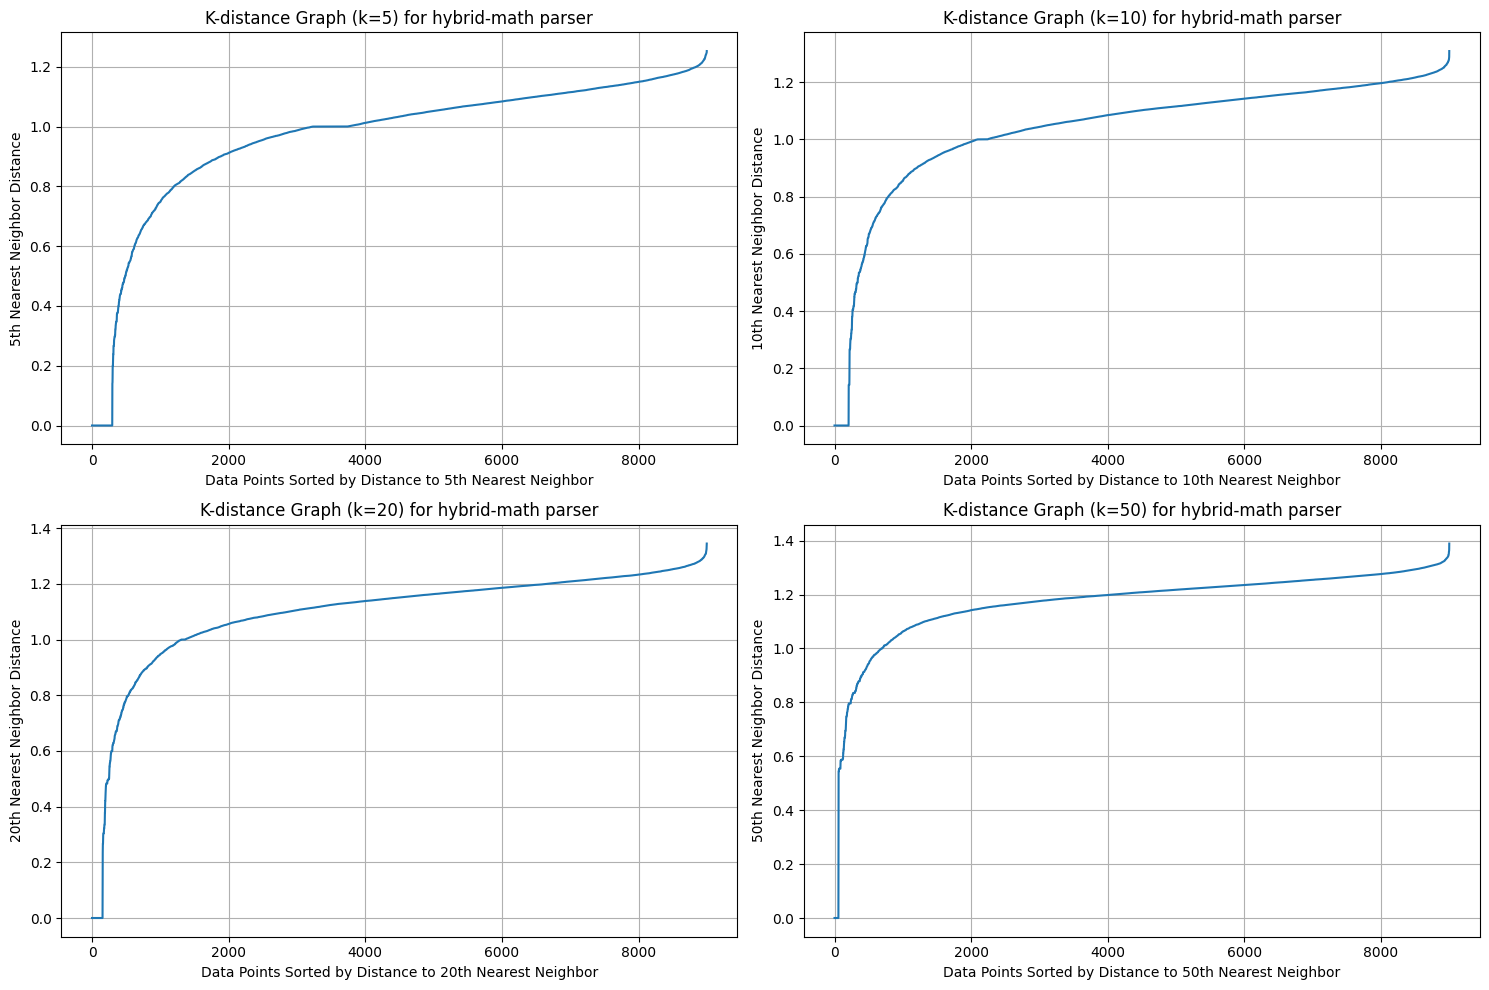

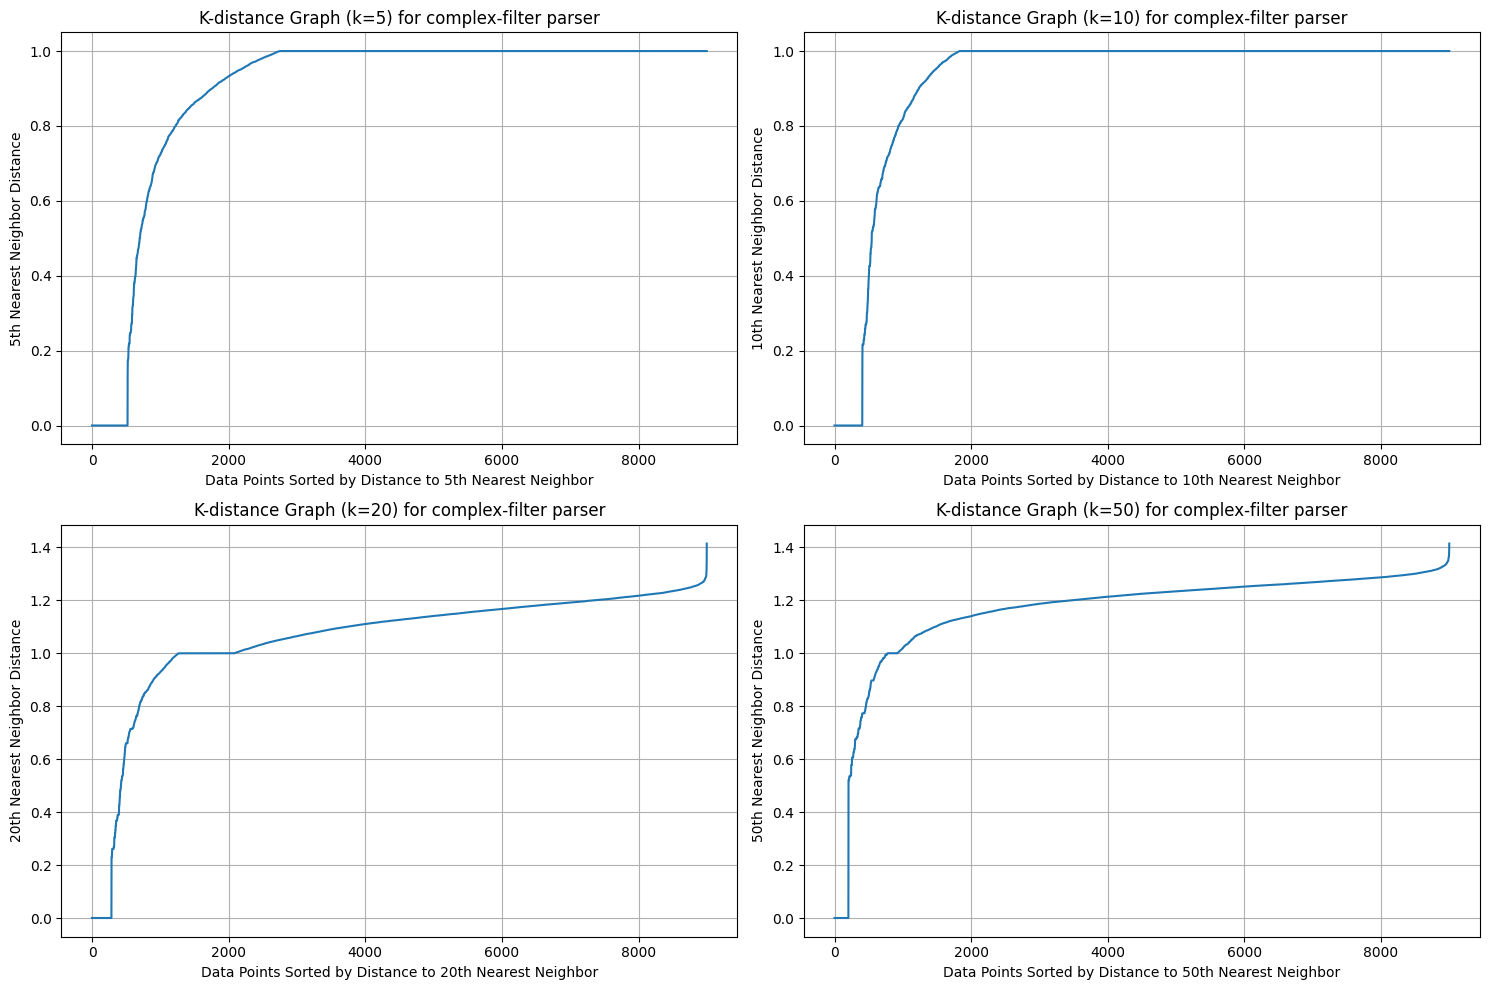

In [ ]:
# 1. Parameter Optimization for 'eps' using k-distance graphs for different 'k'
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  n_neighbors_values = [5, 10, 20, 50]
  plt.figure(figsize=(15, 10))

  for i, n_neighbors_value in enumerate(n_neighbors_values):
      neighbors = NearestNeighbors(n_neighbors=n_neighbors_value)
      neighbors_fit = neighbors.fit(X_vec)
      distances, indices = neighbors_fit.kneighbors(X_vec)
      distances = np.sort(distances, axis=0)
      distances = distances[:, n_neighbors_value - 1]
      plt.subplot(2, 2, i + 1)
      plt.plot(distances)
      plt.title(f'K-distance Graph (k={n_neighbors_value}) for {name} parser')
      plt.xlabel('Data Points Sorted by Distance to {}th Nearest Neighbor'.format(n_neighbors_value))
      plt.ylabel(f'{n_neighbors_value}th Nearest Neighbor Distance')
      plt.grid(True)

  plt.tight_layout()
  plt.show()

In [ ]:
# Based on the k-distance graphs, choose a few potential 'eps' values to test
results_ds = {}
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  potential_eps_values = np.linspace(0.8, 1.1, 10)
  min_samples_values = [5, 10, 15]
  results = []

  for eps in potential_eps_values:
      for min_samples in min_samples_values:
          dbscan = DBSCAN(eps=eps, min_samples=min_samples)
          cluster_labels = dbscan.fit_predict(X_vec)
          n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
          n_noise = list(cluster_labels).count(-1)

          silhouette_avg = -1
          if n_clusters > 1 and n_noise < len(cluster_labels)*0.8:
              silhouette_avg = silhouette_score(X_vec[cluster_labels != -1], cluster_labels[cluster_labels != -1])

          results.append({
              'eps': eps,
              'min_samples': min_samples,
              'n_clusters': n_clusters,
              'n_noise': n_noise,
              'silhouette_score': silhouette_avg
          })

  result_df = pd.DataFrame(results)
  print(f"\nComparison of DBSCAN results for different parameters ({name} parser):")
  print(result_df.sort_values(by='silhouette_score', ascending=False))
  results_ds[name] = result_df


Comparison of DBSCAN results for different parameters (hybrid-math parser):
         eps  min_samples  n_clusters  n_noise  silhouette_score
3   0.833333            5          69     7106          0.095111
14  0.933333           15          14     7014          0.059196
6   0.866667            5          60     6778          0.039959
10  0.900000           10          25     6996          0.032224
13  0.933333           10          22     6532          0.029380
17  0.966667           15          16     6511          0.026843
16  0.966667           10          18     5969          0.004130
19  1.000000           10           2     1297         -0.006405
9   0.900000            5          50     6363         -0.006634
20  1.000000           15           3     1446         -0.009825
12  0.933333            5          46     5833         -0.011787
18  1.000000            5           5     1060         -0.023802
15  0.966667            5          52     5192         -0.028835
5   0.833333 

In [ ]:
# Extract the parameters with the highest Silhouette Score
best_eps = {}
best_min_samples = {}
best_silhouette_score = {}
best_n_clusters = {}
best_n_noise = {}
for name, results_df in results_ds.items():
  best_result = results_df.sort_values(by='silhouette_score', ascending=False).iloc[0]

  best_eps[name] = best_result['eps']
  best_min_samples[name] = int(best_result['min_samples'])
  best_silhouette_score[name] = best_result['silhouette_score']
  best_n_clusters[name] = best_result['n_clusters']
  best_n_noise[name] = best_result['n_noise']

  print(f"\nBest DBSCAN parameters based on Silhouette Score ({name} parser):")
  print(f"  eps: {best_eps[name]}")
  print(f"  min_samples: {best_min_samples[name]}")
  print(f"  Silhouette Score: {best_silhouette_score[name]:.4f}")
  print(f"  Number of Clusters: {best_n_clusters[name]}")
  print(f"  Number of Noise Points: {best_n_noise[name]}")


Best DBSCAN parameters based on Silhouette Score (hybrid-math parser):
  eps: 0.8333333333333334
  min_samples: 5
  Silhouette Score: 0.0951
  Number of Clusters: 69.0
  Number of Noise Points: 7106.0

Best DBSCAN parameters based on Silhouette Score (complex-filter parser):
  eps: 0.9333333333333333
  min_samples: 15
  Silhouette Score: 0.1236
  Number of Clusters: 15.0
  Number of Noise Points: 7156.0


Top terms per DBSCAN cluster (excluding noise) for hybrid-math parser:
Cluster 0:	['legendre', 'f)].', '(x**2', 'arc', '(p', 'Interval.Lopen(0,', 'Eq(t**2*y', '(with', 'Eq(z,', "'yes'"]
Cluster 1:	['Interval(a,', 'legendre', 'f)].', '(x**2', 'alpha],', 'f:x\\to\\mathbb{r}]', 'condition', '(p', 'double', '(with']
Cluster 2:	["'true'", 'powers', 'k]', 'identify', 'start', 'prime', 'legendre', 'f)].', '(x**2', 'Interval.Lopen(0,']
Cluster 3:	['Eq(y_1,', 'legendre', 'f)].', '(x**2', 'f:x\\to\\mathbb{r}]', '(0,', '(1', 'time?', 'double', '(with']
Cluster 4:	['Interval.open(-1,', 'legendre', '(x**2', 'f)].', 'condition', 'cube', '(with', 'defines', 'defined', 'define']
Cluster 5:	['Eq(1,', '(p', 'legendre', 'Eq(t**2*y', 'f)].', '(y', 'Eq(z,', '(x**2', 'initially,', 'Eq(x_1']
Cluster 6:	['Interval.open(2,', 'f)].', 'legendre', 'arc', '(x**2', 'Eq(t**2*y', '(a', "'yes'", 'defined', 'd]?']
Cluster 7:	['Integral(f(x),', 'legendre', 'f)].', '(x**2', 'Eq(t**2*y', 'Eq(sigma,', 'v)].', 'Eq(c,', 'adj

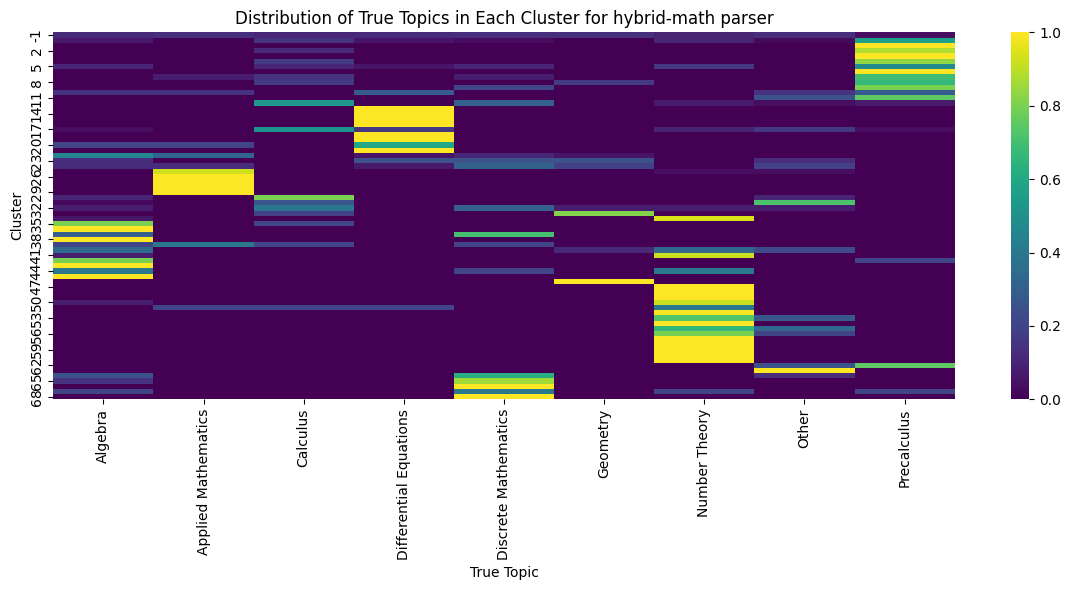

Top terms per DBSCAN cluster (excluding noise) for complex-filter parser:
Cluster 0:	['limit:', 'evaluate', '+', '-', 'oo,', 'x,', "dir='-')]", 'n,', 'calculate', 'limit']
Cluster 1:	['statement', 'false:', 'true', 'following', 'determine', 'answer.', 'justification', 'provide', 'uniformly', 'bounded']
Cluster 2:	['solutions', 'equation', 'number', '-', 'determine', 'real', 'Eq(f(x),', 'differential', 'satisfy', '+']
Cluster 3:	['Eq(y(0),', 'initial', 'solve', 'differential', 'equation', '+', 'condition', 'conditions', '-', 'y,']
Cluster 4:	['<', '&', '(0', '(x', 'x)', 'joint', 'y),', '(y', 'probability', 'density']
Cluster 5:	['<=', '&', '(0', 'x)', '(x', '+', '(y', 'value', 'maximum', 'y)']
Cluster 6:	['convergence', '(n,', 'series', 'series:', 'oo))]', 'radius', 'infinite', 'power', 'oo))].', '+']
Cluster 7:	['oo))]', 'converges.', 'values', 'series', '(n,', 'determine', '(x,', '+', 'integral', 'p]']
Cluster 8:	['residue', 'Eq(z,', 'Eq(f(z),', 'function', '-', 'pole', 'calculate', '

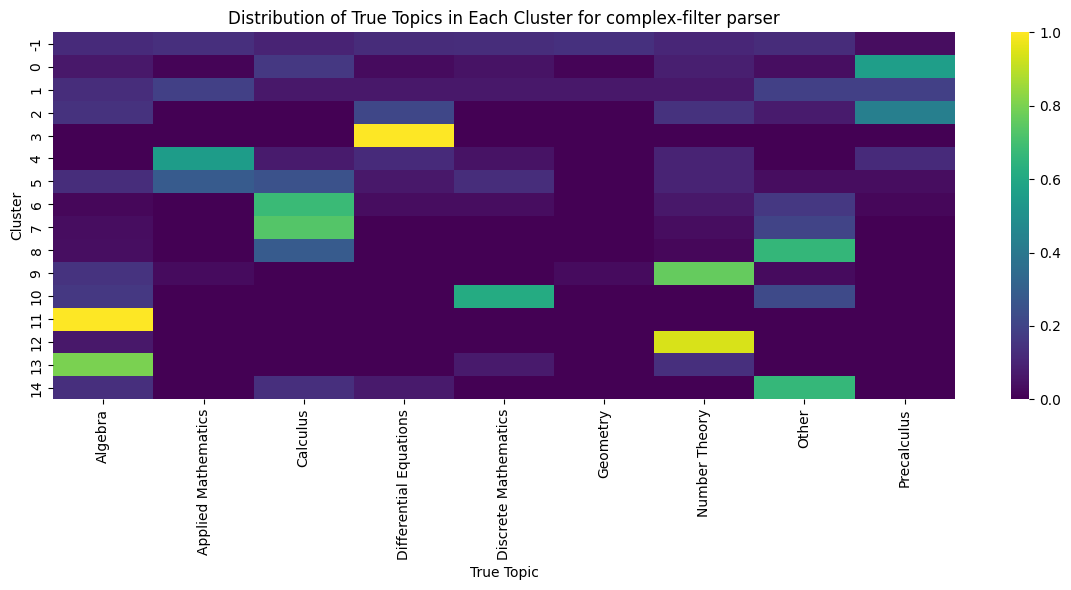

In [ ]:
import seaborn as sns
import plotly.graph_objects as go
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  dbscan = DBSCAN(eps=best_eps[name], min_samples=best_min_samples[name])
  labels_dbscan = dbscan.fit_predict(X_vec)

  print(f"Top terms per DBSCAN cluster (excluding noise) for {name} parser:")
  #vocab = vectorizer.get_feature_names_out()

  for label in range(max(labels_dbscan)+1):
      # Get indices of data points belonging to the current cluster
      cluster_indices = np.where(labels_dbscan == label)[0]
      cluster_samples = X_vec[cluster_indices]

      if cluster_samples.shape[0] > 0:
          # Calculate the mean TF-IDF vector for the cluster
          mean_tfidf = np.array(cluster_samples.mean(axis=0))[0]

          # Sort terms by their mean TF-IDF score in descending order
          sorted_indices = np.argsort(mean_tfidf)[::-1]
          top_terms = [vocab[i] for i in sorted_indices[:10]]
          print(f"Cluster {label}:\t{top_terms}")
      else:
          print(f"Cluster {label}:\t(empty)")

  # Analyze noise points (label -1) if present
  if -1 in labels_dbscan:
      noise_indices = np.where(labels_dbscan == -1)[0]
      print(f"\nNumber of noise points: {len(noise_indices)}")
      print("Example noise points:",)
      maxind = min(10,len(noise_indices))
      for idx in range(maxind):
          print(f"  {idx}: {train_clust[idx]}")

  # Create a DataFrame to tabulate results
  df_vis = pd.DataFrame({
      'Cluster': labels_dbscan,
      'Topic': labels_clust
  })

  # Filter out noise if using DBSCAN (-1 means noise)
  #df_vis = df_vis[df_vis['Cluster'] != -1]

  # Create a contingency table (Cluster x Topic)
  cluster_topic_counts = pd.crosstab(df_vis['Cluster'], df_vis['Topic'])

  # Normalize rows for proportion visualization
  cluster_topic_props = cluster_topic_counts.div(cluster_topic_counts.sum(axis=1), axis=0)

  # Plot heatmap
  plt.figure(figsize=(12, 6))
  sns.heatmap(cluster_topic_props, annot=False, cmap="viridis", cbar=True)
  plt.title(f"Distribution of True Topics in Each Cluster for {name} parser")
  plt.xlabel("True Topic")
  plt.ylabel("Cluster")
  plt.tight_layout()
  plt.show()


  pca = PCA(n_components=3)
  reduced_features = pca.fit_transform(X_vec.toarray())
  '''
  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=labels_dbscan, cmap='viridis')
  plt.title(f'PCA {name} parser')
  plt.show()
  '''
  # Interactive 3D scatter plot
  fig = go.Figure(data=[go.Scatter3d(
      x=reduced_features[:, 0],
      y=reduced_features[:, 1],
      z=reduced_features[:, 2],
      mode='markers',
      marker=dict(
          size=5,
          color=labels_dbscan,     # Color by cluster label
          colorscale='Viridis',
          opacity=0.8
      ),
      text=[f"Index: {i}" for i in range(len(labels_dbscan))]  # Optional: custom hover text
  )])

  fig.update_layout(
      title=f'PCA {name} parser',
      scene=dict(
          xaxis_title='PCA 1',
          yaxis_title='PCA 2',
          zaxis_title='PCA 3'
      ),
      margin=dict(l=0, r=0, b=0, t=40)
  )

  fig.show()

### Hierarchical clustering

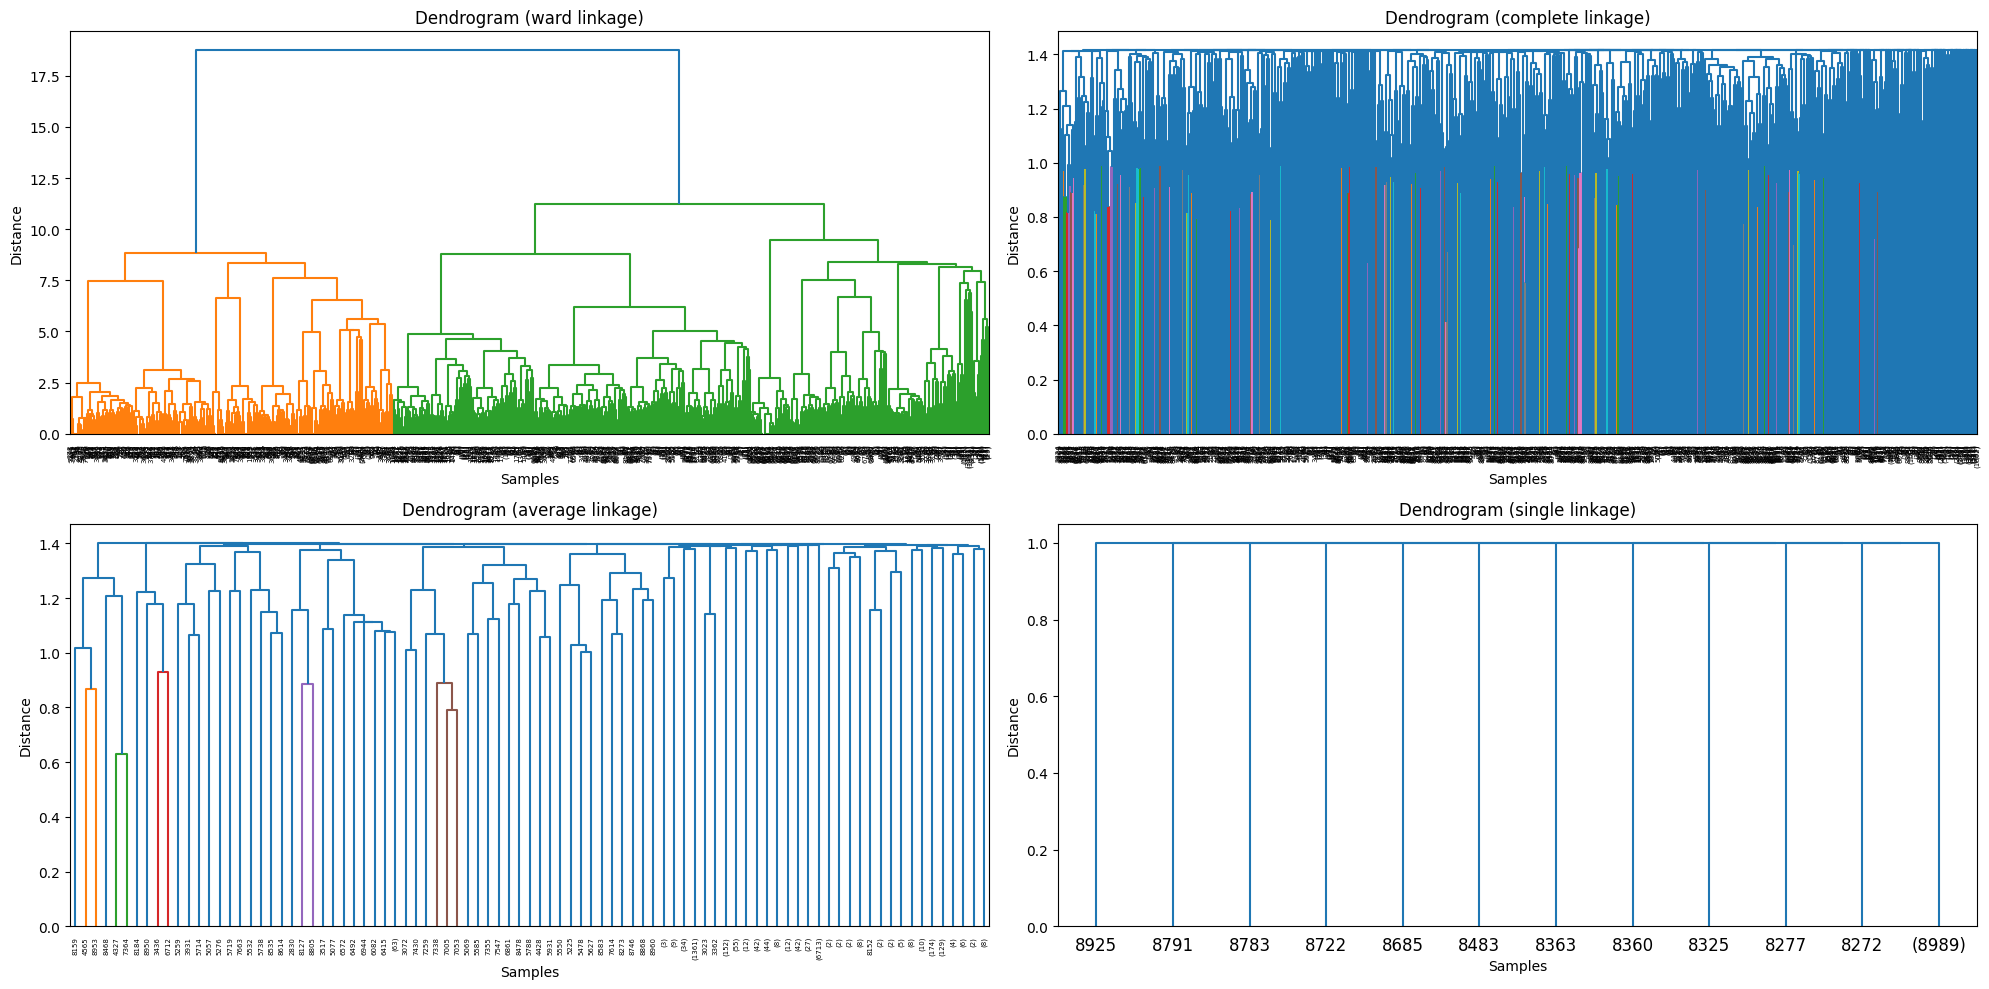

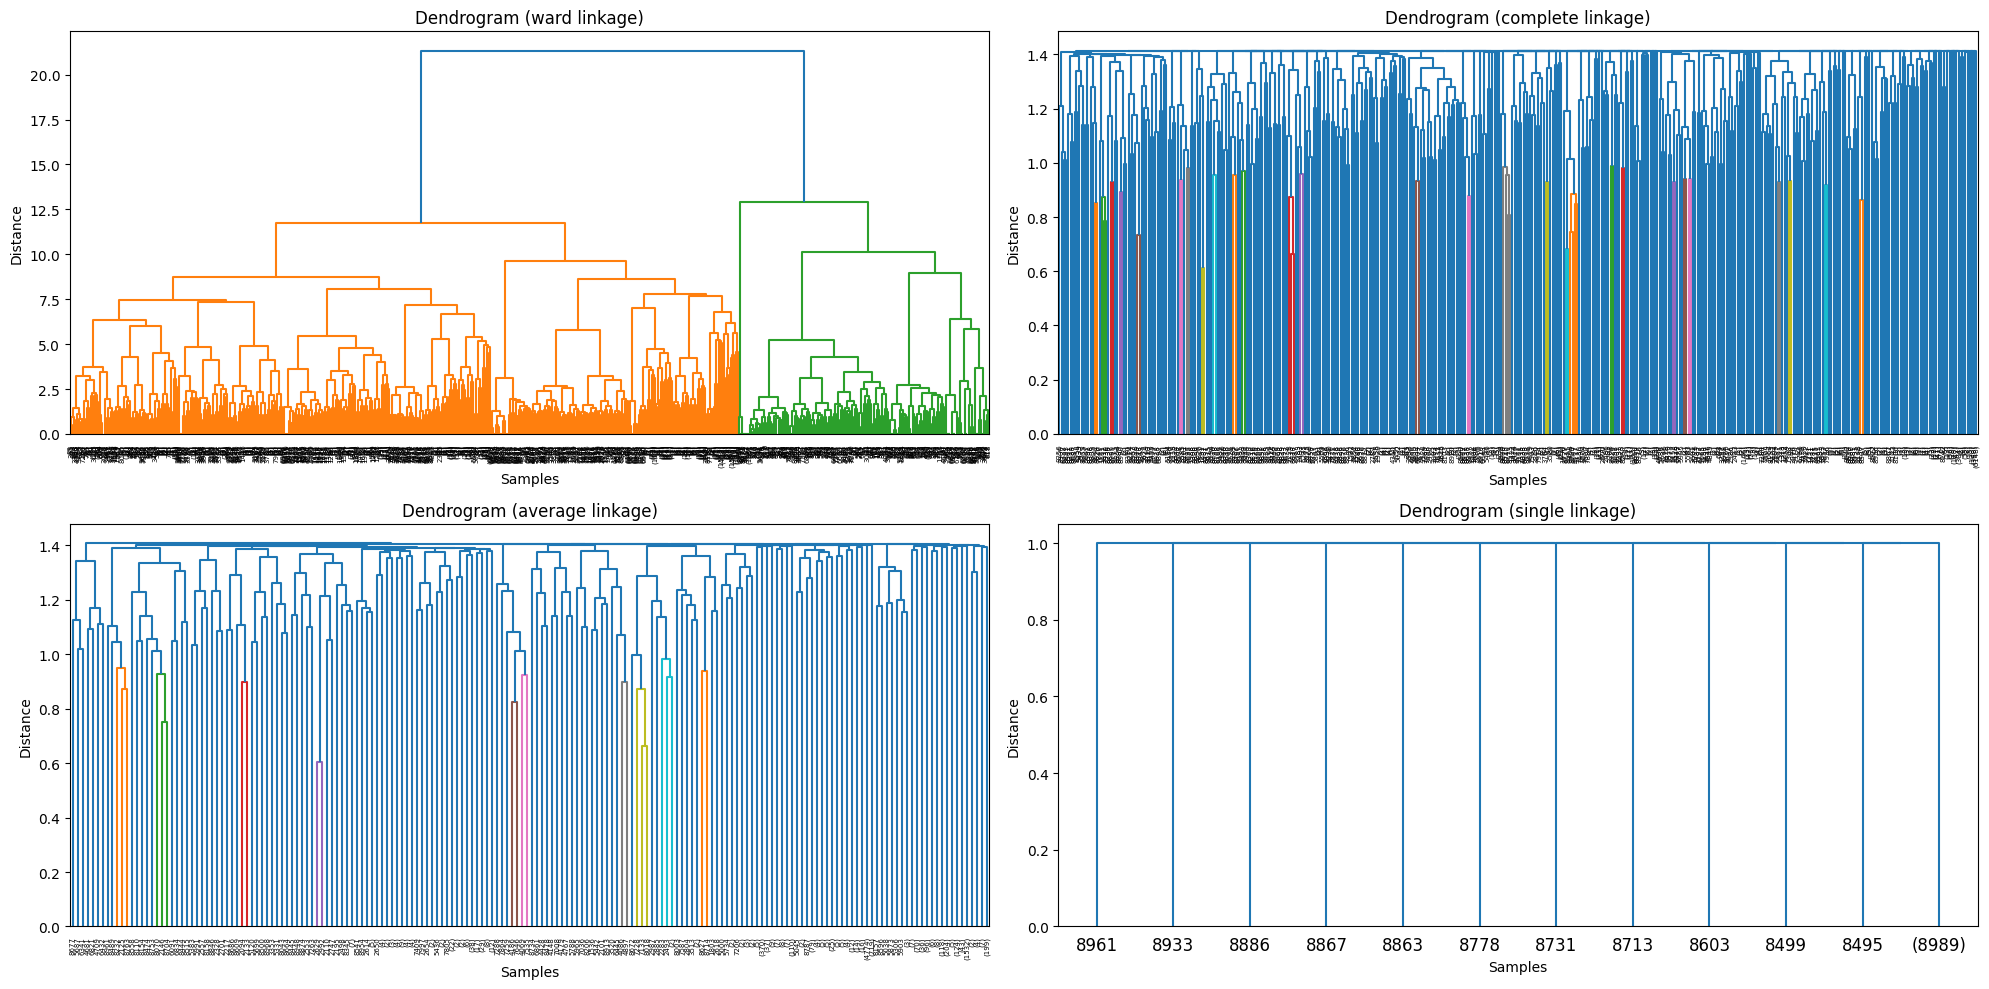

In [ ]:
# Linkage methods to compare
methods = ['ward', 'complete', 'average','single']

for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  # Plot each dendrogram
  plt.figure(figsize=(20, 10))

  for i, method in enumerate(methods):
      plt.subplot(2, 2, i + 1)
      linked = linkage(X_vec.toarray(), method=method)
      dendrogram(linked, truncate_mode='level', p=10)
      plt.title(f'Dendrogram ({method} linkage)')
      plt.xlabel('Samples')
      plt.ylabel('Distance')

  plt.tight_layout()
  plt.show()


In [ ]:
# Fit Agglomerative Clustering with Ward linkage
n_clusters = [3, 4]
linkages = ['ward'] * 2
df_out = {}
for n, name, X_vec, link  in zip(n_clusters, ['hybrid-math', 'complex-format'], X_vecs, linkages):
  model_hierarchical = AgglomerativeClustering(n_clusters=n, linkage=link)
  labels_hierarchical = model_hierarchical.fit_predict(X_vec.toarray())

  df_out[name] = pd.DataFrame({
      'cluster': labels_hierarchical,  # Clustering results
      'topic': labels_clust            # Topic labels
  })

  # Create a pivot table to visualize the distribution of topics across clusters
  topic_distribution = pd.crosstab(df_out[name]['cluster'], df_out[name]['topic'], rownames=['Cluster'], colnames=['Topic'])
  print(f'{name} parser\n\n', topic_distribution)

hybrid-math parser Topic    Algebra  Applied Mathematics  Calculus  Differential Equations  \
Cluster                                                                   
0            851                  961       771                     526   
1             18                    7       104                       9   
2            131                   32       125                     465   

Topic    Discrete Mathematics  Geometry  Number Theory  Other  Precalculus  
Cluster                                                                     
0                         925       938            865    909          253  
1                          32         0             37     26          679  
2                          43        62             98     65           68  
complex-format parser Topic    Algebra  Applied Mathematics  Calculus  Differential Equations  \
Cluster                                                                   
0              9                    2        46 

In [ ]:
for name, X_vec, vec in zip(['hybrid-math', 'complex-filter'], X_vecs, vectorizers):
  print(f"Top terms per hierarchical clusters with {name} parser:")
  vocab = vec.get_feature_names_out()

  for label in range(max(labels_hierarchical)+1):
      # Get indices of data points belonging to the current cluster
      cluster_indices = np.where(labels_hierarchical == label)[0]
      cluster_samples = X_vec[cluster_indices]

      if cluster_samples.shape[0] > 0:
          # Calculate the mean TF-IDF vector for the cluster
          mean_tfidf = np.array(cluster_samples.mean(axis=0))[0]

          # Sort terms by their mean TF-IDF score in descending order
          sorted_indices = np.argsort(mean_tfidf)[::-1]
          top_terms = [vocab[i] for i in sorted_indices[:10]]
          print(f"Cluster {label}:\t{top_terms}")
      else:
          print(f"Cluster {label}:\t(empty)")

Top terms per hierarchical clusters with hybrid-math parser:
Cluster 0:	['limit', ':', 'evaluate', '\\to', '\\infty}', 'calculate', '\\lim_{n', '\\lim_{x', '\\lim_{x\\to', 'compute']
Cluster 1:	['.', ',', '=', 'x', '-', '?', 'determine', 'n', '+', 'number']
Cluster 2:	['evaluate', 'limit', ':', '\\to', '\\lim_{x', '\\infty}', '\\lim_{n', '+', '\\lim_{x\\to', '\\lim']
Cluster 3:	['+', '=', '.', 'equation', '-', ',', 'differential', ':', 'evaluate', 'x']
Top terms per hierarchical clusters with complex-filter parser:
Cluster 0:	['limit:', "dir='-')]", 'oo,', 'evaluate', '+', 'x,', 'n,', 'calculate', "dir='+')]", '-']
Cluster 1:	['determine', '+', 'let', 'number', 'set', 'given', 'x]', 'function', 'value', 'space']
Cluster 2:	['limit:', 'evaluate', 'using', 'distribution,', 'distributed', 'distribute', 'distinct', 'distances', 'distance.', 'distance']
Cluster 3:	['+', '-', 'equation', 'evaluate', 'differential', 'determine', 'value', 'function', 'integral', 'given']


In [ ]:
print(df_out)

{'hybrid-math':       cluster                 topic
0           1           Precalculus
1           1           Precalculus
2           1           Precalculus
3           1           Precalculus
4           1           Precalculus
...       ...                   ...
8995        2  Discrete Mathematics
8996        2  Discrete Mathematics
8997        0  Discrete Mathematics
8998        0  Discrete Mathematics
8999        0  Discrete Mathematics

[9000 rows x 2 columns], 'complex-format':       cluster                 topic
0           0           Precalculus
1           0           Precalculus
2           0           Precalculus
3           0           Precalculus
4           2           Precalculus
...       ...                   ...
8995        3  Discrete Mathematics
8996        3  Discrete Mathematics
8997        1  Discrete Mathematics
8998        1  Discrete Mathematics
8999        1  Discrete Mathematics

[9000 rows x 2 columns]}


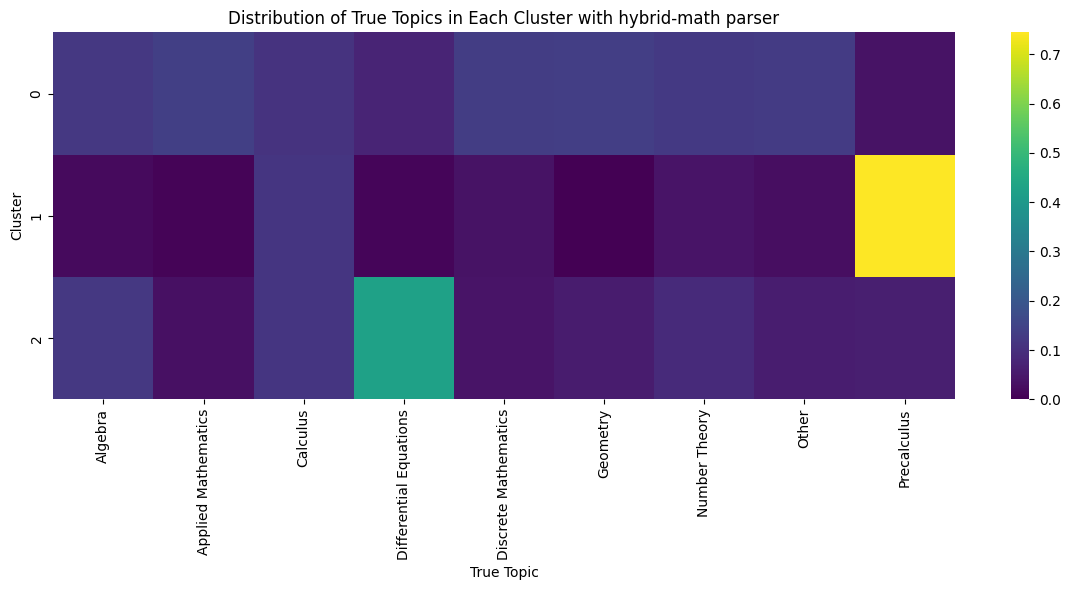

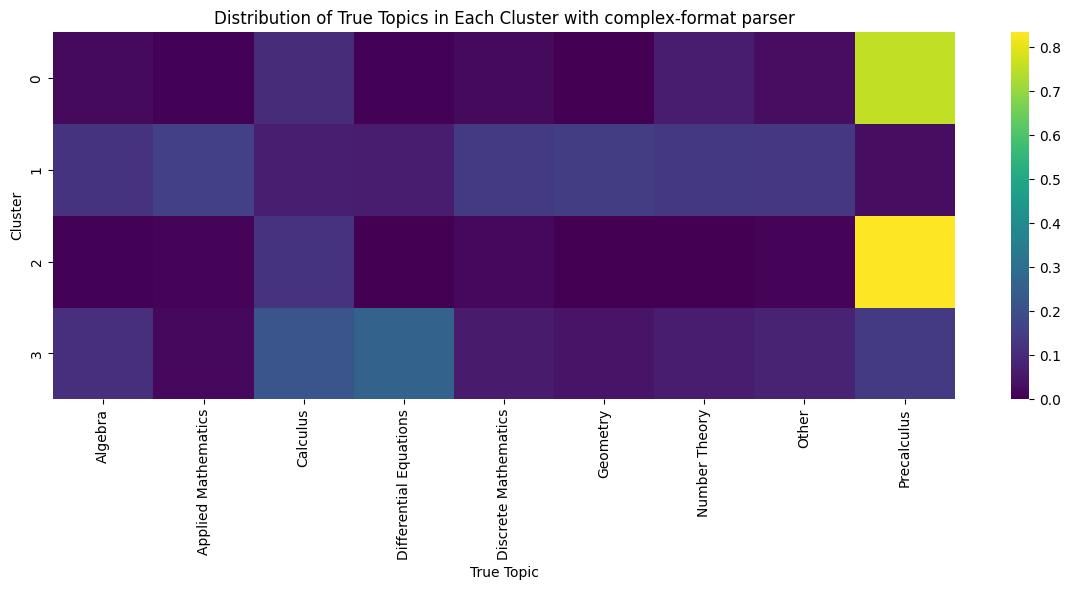

In [ ]:
import seaborn as sns
for name, df_vis in df_out.items():
  # Create a contingency table (Cluster x Topic)
  cluster_topic_counts = pd.crosstab(df_vis['cluster'], df_vis['topic'])

  # Normalize rows for proportion visualization
  cluster_topic_props = cluster_topic_counts.div(cluster_topic_counts.sum(axis=1), axis=0)

  # Plot heatmap
  plt.figure(figsize=(12, 6))
  sns.heatmap(cluster_topic_props, annot=False, cmap="viridis", cbar=True)
  plt.title(f"Distribution of True Topics in Each Cluster with {name} parser")
  plt.xlabel("True Topic")
  plt.ylabel("Cluster")
  plt.tight_layout()
  plt.show()


In [ ]:
for X_vec, (name, df_vis) in zip(X_vecs, df_out.items()):
  pca = PCA(n_components=3)
  reduced_features = pca.fit_transform(X_vec.toarray())

  c_labels = np.asarray(df_vis['cluster'])

  # Create interactive 3D scatter plot
  fig = go.Figure(data=[go.Scatter3d(
      x=reduced_features[:, 0],
      y=reduced_features[:, 1],
      z=reduced_features[:, 2],
      mode='markers',
      marker=dict(
          size=5,
          color=c_labels,
          colorscale='Viridis',
          opacity=0.8,
          colorbar=dict(title="Cluster")
      ),
      text=[f"Index: {i}, Cluster: {label}" for i, label in enumerate(c_labels)]
  )])

  fig.update_layout(
      title=f'PCA with {name} parser',
      scene=dict(
          xaxis_title='PCA 1',
          yaxis_title='PCA 2',
          zaxis_title='PCA 3'
      ),
      margin=dict(l=0, r=0, b=0, t=40)
  )

  fig.show()

### LDA

In [13]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer #need this one for LDA

In [ ]:
# Vectorize the text
tokenizer = Tokenizer('hybrid-math', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_hybrid_math = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.5, min_df=5, stop_words='english')
X_vec_hybrid_math = vectorizer_hybrid_math.fit_transform(train_clust)

tokenizer = Tokenizer('complex-filter', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_complex_filter = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.5, min_df=5, stop_words='english')
import sys
sys.set_int_max_str_digits(20000)
X_vec_complex_filter = vectorizer_complex_filter.fit_transform(train_clust)

X_vecs = [X_vec_hybrid_math, X_vec_complex_filter]
vectorizers = [vectorizer_hybrid_math, vectorizer_complex_filter]

for v in vectorizers:
  vocab = v.get_feature_names_out()
  print("Vocab length:", len(vocab))

Vocab length: 2533
Vocab length: 2788


In [15]:
LDAs = {}
for X_vec, name in zip(X_vecs, ['hybrid-math', 'complex-filter']):
  lda = LatentDirichletAllocation(n_components=5, verbose=1, learning_method='online', max_iter=30)
  lda.fit(X_vec)
  LDAs[name] = lda

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_it

In [16]:
# Most important terms for each topic (n=3000)
for name, lda in LDAs.items():
  print(f'\n{name} parser')
  for i in range(len(lda.components_)):
      sorted_terms = lda.components_[i].argsort()[::-1]
      concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
      print (f'Topic {i + 1}:\t', concatenated_terms)


hybrid-math parser
Topic 1:	 [(x,, (p, symbols, (r, topology, f(1))], generator, h], straight, domain]
Topic 2:	 [previous, moves, 'false'., orientable, 'true', parametric, (y,, domain, usual, standard]
Topic 3:	 [(x,, (n,, maximal, 'yes', domain, moves, (r, certain, (p, near]
Topic 4:	 [Eq(r,, (y,, symbols, laplace, (x,, (r, q, domain, linearly, real]
Topic 5:	 [(with, lebesgue, f(z)], arbitrarily, Eq(t(1),, order,, (r, integrable, (p, Eq(y_2,]

complex-filter parser
Topic 1:	 [evaluate, limit:, oo,, prime, n,, using, numbers, x,, -, limit]
Topic 2:	 [number, determine, given, probability, random, calculate, point, value, n], let]
Topic 3:	 [<=, <, &, positive, integer, determine, given, equation, integers, number]
Topic 4:	 [+, -, equation, value, given, differential, determine, x, integral, Eq(y,]
Topic 5:	 [let, determine, function, set, x], does, space, exists, consider, provide]



hybrid-math parser


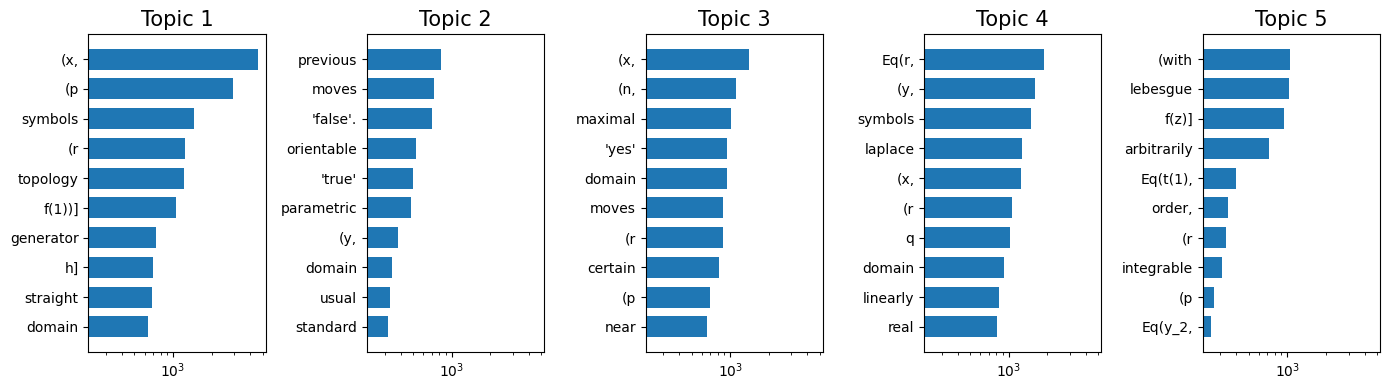


complex-filter parser


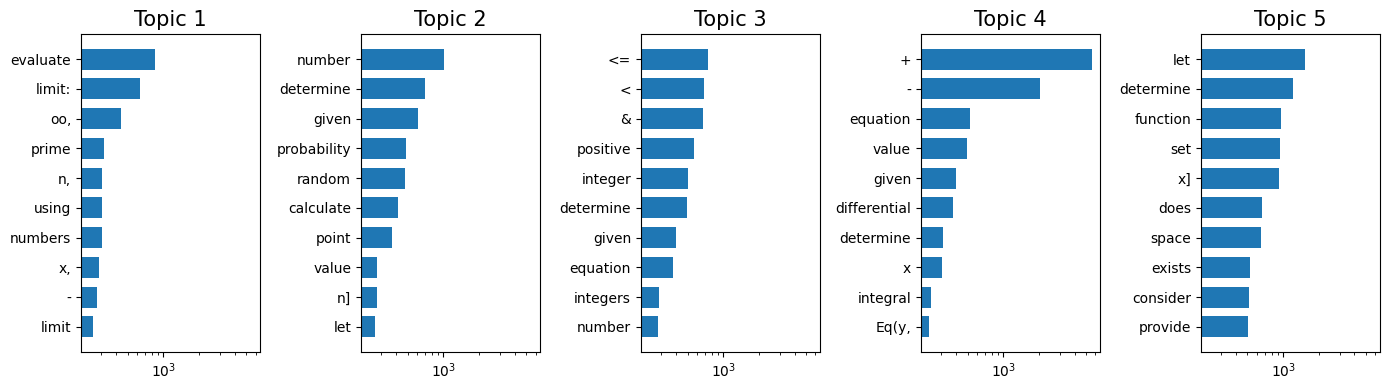

In [17]:
for name, lda in LDAs.items():
  print(f'\n{name} parser')
  num_words = 10
  cols = 5
  rows = int(len(lda.components_)/5)

  fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(lda.components_):
      top_terms_index = topic.argsort()[:-num_words - 1:-1]
      top_terms = [vocab[i] for i in top_terms_index]
      weights = topic[top_terms_index]
      ax = axes[topic_idx]
      ax.barh(top_terms, weights, height=0.7)
      ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
      ax.invert_yaxis()
      ax.set_xscale('log')

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.tight_layout()
  plt.show()

In [20]:
# Analyse one document in particular
doc = train_clust[1160]
print('Analysing the document:\n', doc)

for vectorizer, lda, name in zip(vectorizers, LDAs.values(), ['hybrid-math', 'complex-filter']):
  print(f'{name} parser')
  doc_vec = vectorizer.transform([doc])[0]
  topic_vec = lda.transform(doc_vec)[0]
  print(topic_vec)

  sorted_topics = topic_vec.argsort()[::-1]
  sorted_prevalence = sorted(topic_vec)[::-1]

  # Relevance and top terms for the question for each topic
  for i in range(len(sorted_prevalence)):
      if sorted_prevalence[i] < .01: break
      topic = sorted_topics[i]
      sorted_terms = np.flip(lda.components_[topic].argsort())
      print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

Analysing the document:
 Solve the differential equation \(( D^4 + 6 D^3 + 9 D^2) y=0\), where \(D = \frac{d}{dx}\), with the initial conditions \(x=0,  y=0,  y'=0,  y''= 6\), and the asymptotic condition that as \(x\) tends to \(+\infty\), \(y'\) tends to \(1\). Find the value of \(y\) when \(x = 1\).
hybrid-math parser
[0.78647813 0.0083404  0.18843145 0.00837594 0.00837408]
78.6% Topic 0: (x, (p symbols (r topology f(1))] generator h] straight domain
18.8% Topic 2: (x, (n, maximal 'yes' domain moves (r certain (p near
complex-filter parser
[0.01000039 0.01001481 0.16316615 0.60505013 0.21176851]
60.5% Topic 3: + - equation value given differential determine x integral Eq(y,
21.2% Topic 4: let determine function set x] does space exists consider provide
16.3% Topic 2: <= < & positive integer determine given equation integers number
1.0% Topic 1: number determine given probability random calculate point value n] let
1.0% Topic 0: evaluate limit: oo, prime n, using numbers x, - limit


#### LDA Optimization

In [ ]:
from sklearn.model_selection import train_test_split

documents_train, documents_test= train_test_split(train_clust, test_size=0.2, random_state=11)
print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

tokenizer = Tokenizer('hybrid-math', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_hybrid_math = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.5, min_df=5, stop_words='english')
X_vec_hybrid_math_train = vectorizer_hybrid_math.fit_transform(documents_train)
X_vec_hybrid_math_test = vectorizer_hybrid_math.fit_transform(documents_test)

tokenizer = Tokenizer('complex-filter', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_complex_filter = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.5, min_df=5, stop_words='english')
import sys
sys.set_int_max_str_digits(20000)
X_vec_complex_filter_train = vectorizer_complex_filter.fit_transform(documents_train)
X_vec_complex_filter_test = vectorizer_complex_filter.fit_transform(documents_test)

X_vecs_train = [X_vec_hybrid_math_train, X_vec_complex_filter_train]
X_vecs_test = [X_vec_hybrid_math_test, X_vec_complex_filter_test]
vectorizers = [vectorizer_hybrid_math, vectorizer_complex_filter]

for v in vectorizers:
  vocab = v.get_feature_names_out()
  print("Vocab length:", len(vocab))

No. training docs: 7200
No. testing docs: 1800
Vocab length: 808
Vocab length: 820


Number of Topics: 5, Perplexity: 13713.6692
Number of Topics: 7, Perplexity: 15395.2566
Number of Topics: 10, Perplexity: 17712.0563
Number of Topics: 12, Perplexity: 18893.8976
Number of Topics: 15, Perplexity: 19333.5456


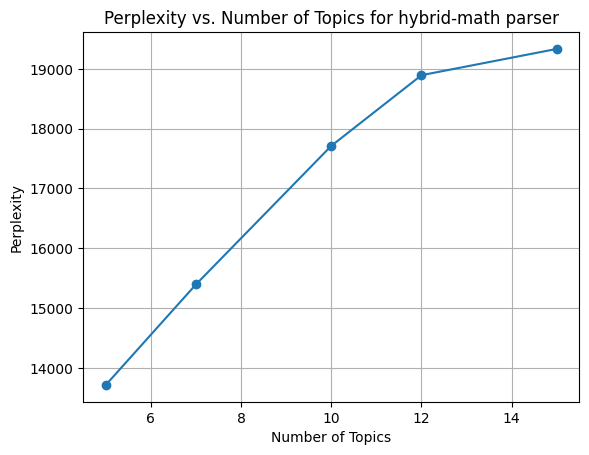

Number of Topics: 5, Perplexity: 14363.4468
Number of Topics: 7, Perplexity: 15743.0748
Number of Topics: 10, Perplexity: 19476.8162
Number of Topics: 12, Perplexity: 21644.4578
Number of Topics: 15, Perplexity: 23727.5703


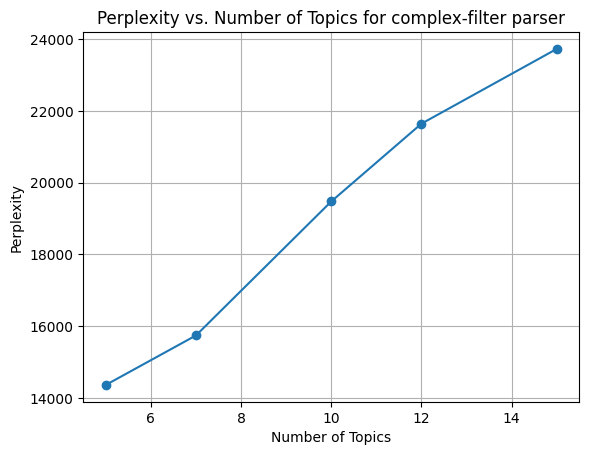

In [22]:
perplexity_values = {}
topic_range = [5, 7, 10, 12, 15]

for vector_documents_train, vector_documents_test, name in zip(X_vecs_train, X_vecs_test, ['hybrid-math', 'complex-filter']):
  for n_topics in topic_range:
      lda = LatentDirichletAllocation(n_components=n_topics, verbose=0,
                                      learning_method='online', max_iter=30,
                                      random_state=seed)
      lda.fit(vector_documents_train)
      perplexity = lda.perplexity(vector_documents_test)
      perplexity_values[n_topics] = perplexity
      print(f"Number of Topics: {n_topics}, Perplexity: {perplexity:.4f}")

  plt.plot(list(perplexity_values.keys()), list(perplexity_values.values()), marker='o')
  plt.xlabel("Number of Topics")
  plt.ylabel("Perplexity")
  plt.title(f"Perplexity vs. Number of Topics for {name} parser")
  plt.grid(True)
  plt.show()

### TSNE

In [ ]:
from sentence_transformers import SentenceTransformer
import random
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentence_transformer_model_name = "all-MiniLM-L12-v2"

# Others can be found:
'''
📄 Sentence Embedding Models

    Model Name: sentence-transformers/all-MiniLM-L6-v2

        Embedding Dimension: 384

        Performance: Fast and lightweight; suitable for real-time applications with limited resources.

        Hugging Face URL: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
        Zilliz

    Model Name: sentence-transformers/all-MiniLM-L12-v2

        Embedding Dimension: 384

        Performance: Offers better embedding quality than L6 while maintaining efficiency.

        Hugging Face URL: https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2

    Model Name: sentence-transformers/all-mpnet-base-v2

        Embedding Dimension: 768

        Performance: Achieves higher accuracy in semantic similarity tasks; ideal when accuracy is paramount.

        Hugging Face URL: https://huggingface.co/sentence-transformers/all-mpnet-base-v2
        GitHub+5Hugging Face+5Deep Infra+5
        Hugging Face+2Hugging Face+2Hugging Face+2

    Model Name: Alibaba-NLP/gte-large-en-v1.5

        Embedding Dimension: 1024

        Performance: Supports long context lengths (up to 8192 tokens); achieves state-of-the-art scores on the MTEB benchmark.

        Hugging Face URL: https://huggingface.co/Alibaba-NLP/gte-large-en-v1.5
        GitHub+9Dataloop+9Toolify+9
        Hugging Face+6Hugging Face+6Hugging Face+6

    Model Name: WhereIsAI/UAE-Large-V1

        Embedding Dimension: 1024

        Performance: Recognized for robust performance in various NLP tasks; versatile across different domains requiring high-quality embeddings.

        Hugging Face URL: https://huggingface.co/WhereIsAI/UAE-Large-V1
        Hugging Face+1Hugging Face+1
        Hugging Face+23Hugging Face+23
'''

sentence_to_visualize = 100

model = SentenceTransformer(sentence_transformer_model_name)
# Take random indices between 0 and NUM_SAMPLES of size 100
random_indices = random.sample(range(NUM_SAMPLES), sentence_to_visualize)
sentences = train_ds_qs.iloc[random_indices].tolist()
embeddings = model.encode(sentences)

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# for nbformat errors: https://stackoverflow.com/questions/66557543/valueerror-mime-type-rendering-requires-nbformat-4-2-0-but-it-is-not-installed

# Reduce to 3D
embeddings_3d = TSNE(n_components=3, perplexity=5.0 if len(sentences) < 30 else 30.0).fit_transform(embeddings)
# Map to indexes ase sentences in space are not readable
indices = [f"#{i}" for i in range(len(sentences))]

# 4. Plot
fig = px.scatter_3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    text=indices,
    title="3D Sentence Embeddings (Index View)",
)
fig.show()

# 5. Print index-to-sentence mapping
for i, s in enumerate(sentences):
    print(f"{i}: {s}")

0: Suppose $f(x)$ and $g(x)$ are continuous, differentiable, positive, and monotone decreasing functions such that $\lim_{x \to \infty} f(x) = \lim_{x \to \infty} g(x) = 0$. If $\int_0^\infty |g(x)-f(x)| \, dx=0$, does it imply that $f(x) = g(x)$ for all $x$? Answer 'yes' or 'no' and justify your answer.
1: Determine whether the sequence \( \{(\sin^2(3+\sin(n)))^n\} \) converges or diverges. If it converges, find its limit.
2: Calculate the value of \( 718^{143} \mod 1260 \).
3: Determine the nature of the singular point \( z = 0 \) of the function \( f(z)=\frac{1}{2+z^{2}-2 \operatorname{ch} z} \).
4: Evaluate the integral: $$\int_{-\pi}^{\pi} \ln (\cos x +\sqrt{1+\cos^2 x}) \, dx$$
5: What is the smallest possible real value of $x^2 + 8x$?
6: If the famous baseball player for the San Francisco Midgets, Larry Ponds, has a $\frac{2}{5}$ chance of earning a walk on each plate appearance, what is the probability that he will earn a walk exactly once in his next two plate appearances? Exp

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

# Assume `embeddings` is a (n_sentences x embedding_dim) array from SBERT
D = cosine_distances(embeddings)

# Set diagonal to infinity to ignore self-distances (which are zero)
np.fill_diagonal(D, np.inf)

# Flatten, sort, and retrieve the smallest distances
n = len(embeddings)
pairs = [(i, j, D[i, j]) for i in range(n) for j in range(i+1, n)]
top_10 = sorted(pairs, key=lambda x: x[2])[:10]

# Print results
for i, j, dist in top_10:
    print(f"Pair #{i} ↔ #{j} | Distance: {dist:.4f}")

Pair #30 ↔ #87 | Distance: 0.4111
Pair #51 ↔ #74 | Distance: 0.4119
Pair #15 ↔ #25 | Distance: 0.4430
Pair #11 ↔ #80 | Distance: 0.4455
Pair #29 ↔ #79 | Distance: 0.4541
Pair #5 ↔ #16 | Distance: 0.4729
Pair #20 ↔ #42 | Distance: 0.4804
Pair #56 ↔ #69 | Distance: 0.5020
Pair #10 ↔ #72 | Distance: 0.5217
Pair #44 ↔ #97 | Distance: 0.5278


# Learning from data

## M1C: Base model (topic classification)

In [ ]:
PARSER = 'hybrid-math'

In [ ]:
print('Working on', train_ds_qs.shape, 'samples')

Working on (20000,) samples


fitted: LinearSVC(max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', loss='log_loss', max_iter=10000)
fitted: LogisticRegression(max_iter=1000, n_jobs=-1)
fitted: MultinomialNB()


model  accuracy  macro_f1
2             SGD-log   0.51400  0.373188
0           LinearSVC   0.59550  0.366134
1           SGD-hinge   0.51000  0.364484
3  LogisticRegression   0.57000  0.303920
4       MultinomialNB   0.39675  0.115594

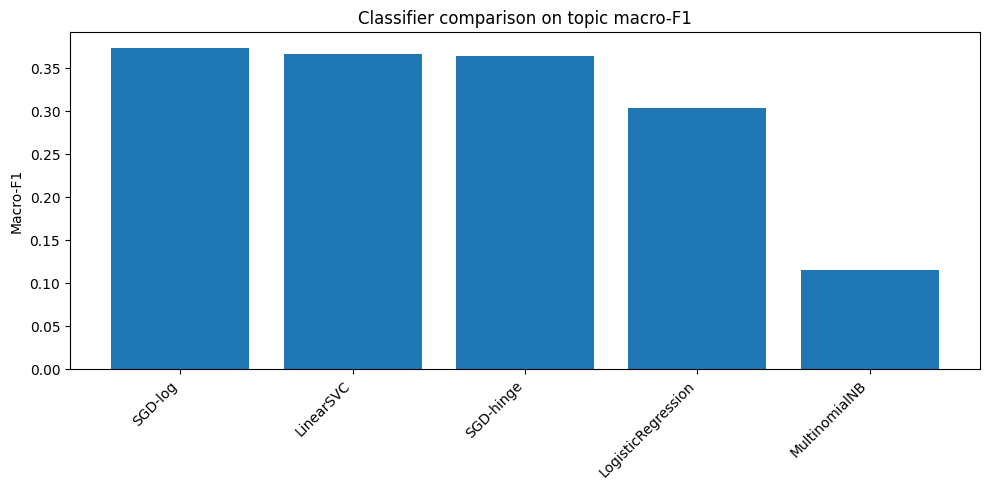

Best model: SGD-log
Accuracy: 0.514
Macro-F1: 0.37318796523188663
Best model class: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>


In [ ]:
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    train_ds_qs, train_ds_tp,
    test_size=0.2, random_state=seed,
    stratify=train_ds_tp
)

# 2. Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

counts = Counter(y_train)
total = len(y_train)

# Inverse‐frequency weights
weights = {cls: total/(len(counts)*cnt) for cls, cnt in counts.items()}

# 3. Select tokenizer
tokenizer = Tokenizer(PARSER, "allenai/longformer-base-4096", remove_numbers=True)

# 4. Define a suite of classifiers to compare
classifiers = {
    "LinearSVC":             LinearSVC(max_iter=10000),
    "SGD-hinge":             SGDClassifier(loss="hinge", class_weight="balanced", max_iter=10000),
    "SGD-log":               SGDClassifier(loss="log_loss",  class_weight="balanced", max_iter=10000),
    "LogisticRegression":    LogisticRegression(max_iter=1000, n_jobs=-1),
    "MultinomialNB":         MultinomialNB(),
}

classifiers_classes = {
    "LinearSVC":             LinearSVC,
    "SGD-hinge":             SGDClassifier,
    "SGD-log":               SGDClassifier,
    "LogisticRegression":    LogisticRegression,
    "MultinomialNB":         MultinomialNB,
}

vectorizer =  TfidfVectorizer(
    tokenizer=tokenizer.parse,
    lowercase=True,
    token_pattern=None
)
X_train_vectorized =  vectorizer.fit_transform(X_train)
X_test_vectorized =  vectorizer.transform(X_test)

# 5. Train, predict, record metrics
results = []
for name, clf in classifiers.items():
    clf.fit(X_train_vectorized, y_train)
    print("fitted:",clf)
    yp = clf.predict(X_test_vectorized)
    results.append({
        "model":    name,
        "accuracy": accuracy_score(y_test, yp),
        "macro_f1": f1_score(y_test, yp, average="macro")
    })

df = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
display(df)

# 6. Plot macro-F1 for easy comparison
plt.figure(figsize=(10,5))
plt.bar(df["model"], df["macro_f1"])
plt.ylabel("Macro-F1")
plt.xticks(rotation=45, ha="right")
plt.title("Classifier comparison on topic macro-F1")
plt.tight_layout()
plt.show()

# Find the best model based on macro_f1
best_result = max(results, key=lambda x: x["macro_f1"])
best_model_name = best_result["model"]

print(f"Best model: {best_model_name}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Macro-F1: {best_result['macro_f1']}")

# Retrieve the corresponding classifier from the classifiers dictionary
best_model_class = classifiers_classes[best_model_name]
print(f"Best model class: {best_model_class}")



Tune the best model with optuna

NB: 50k iters does not reach convergence atm (with tree-walk parser), try with more iters.
NB: 10k iters does not reach convergence atm (with hybrid-math parser), try with more iters.

In [ ]:
X       = train_ds_qs
y_raw   = train_ds_tp
le      = LabelEncoder()
y       = le.fit_transform(y_raw)

N_TRIALS = 2

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=seed,
    stratify=y
)

from collections import Counter
counts = Counter(y_train)
total  = len(y_train)
n_cls  = len(counts)
weights = {
    cls : total/(n_cls * count)
    for cls, count in counts.items()
}

def objective(trial):
    # TF–IDF params
    ngram_min    = trial.suggest_int("ngram_min", 1, 2)
    ngram_max    = trial.suggest_int("ngram_max", ngram_min, 3)
    max_df       = trial.suggest_float("max_df", 0.5, 1.0)
    min_df       = trial.suggest_int("min_df", 1, 5)
    #max_features = int(trial.suggest_int("max_features", 10_000, 50_000, step=5_000))

    max_iter = 10000
    if best_model_name == "LinearSVC":
        C            = trial.suggest_float("C", 1e-4, 1e2, log=True)
        weight_choice = trial.suggest_categorical("weight_choice", ["none", "custom"])
        if weight_choice == "none":
            class_weight = None
        else:
            class_weight = weights
        loss         = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
        dual         = True if loss == "hinge" else False
        model = best_model_class(
            C,
            class_weight=class_weight,
            loss=loss,
            dual=dual,
            max_iter=max_iter,
            random_state=seed
        )
    elif best_model_name in ["SGD-hinge", "SGD-log"]:
        loss         = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
        weight_choice = trial.suggest_categorical("weight_choice", ["none", "custom"])
        if weight_choice == "none":
            class_weight = None
        else:
            class_weight = weights
        model = best_model_class(
            class_weight=class_weight,
            loss=loss,
            max_iter=max_iter,
            random_state=seed
        )
    elif best_model_name == "LogisticRegression":
        model = best_model_class(
            max_iter=max_iter,
            n_jobs = 1
        )
    elif best_model_name == "MultinomialNB":
        model = best_model_class(
        )
    else:
        raise RuntimeError('not impl')


    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
             tokenizer=tokenizer.parse,
             lowercase=True,
             token_pattern=None,
             ngram_range=(ngram_min, ngram_max),
             max_df=max_df,
             min_df=min_df,
             #max_features=max_features,
        )),
        ("clf", model)
    ])


    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
    scorer = make_scorer(f1_score, average="macro")

    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=cv, scoring=scorer, n_jobs=1
    )
    return scores.mean()

study = optuna.create_study(direction="maximize", study_name=f"{best_model_name}_tuning")
study.optimize(objective, n_trials=N_TRIALS, timeout=3600)

best_macro_f1 = study.best_value
best_params = study.best_params

print("Best macro-F1:", study.best_value)
print("Best hyperparameters:", study.best_params)

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Best macro-F1: 0.3213302218062146
Best hyperparameters: {'ngram_min': 1, 'ngram_max': 2, 'max_df': 0.7328585688918821, 'min_df': 1, 'loss': 'hinge', 'weight_choice': 'none'}


Best macro-F1: 0.22819337166898143
Best hyperparameters: {'ngram_min': 1, 'ngram_max': 2, 'max_df': 0.7832138168654517, 'min_df': 1, 'C': 44.281459120039905, 'weight_choice': 'none', 'loss': 'hinge'}

L'ets fit the model with the new params



In [ ]:
X = train_ds_qs
y_raw = train_ds_tp

X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.2, random_state=seed,
	  stratify=y_raw
)

le = LabelEncoder()
y = le.fit_transform(y_raw)

def build_model(model_name):
    max_iter = 10000
    if model_name == "LinearSVC":
        model = best_model_class(
            best_params['C'],
            class_weight=None,
            loss=best_params['loss'],
            max_iter=max_iter,
            random_state=seed
        )
    elif model_name in ["SGD-hinge", "SGD-log"]:
        model = best_model_class(
            class_weight=None,
            loss=best_params['loss'],
            max_iter=max_iter,
            random_state=seed
        )
    elif model_name == "LogisticRegression":
        model = best_model_class(
            max_iter=max_iter,
            n_jobs = 1
        )
    elif model_name == "MultinomialNB":
        model = best_model_class(
        )
    else:
        raise RuntimeError('not impl')
    return model

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=tokenizer.parse,
        lowercase=True,
        token_pattern=None, ngram_range=(best_params['ngram_min'], best_params['ngram_max']), max_df=best_params['max_df'], min_df=best_params['min_df']
    )),
    ("clf", build_model(best_model_name))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.58825

Classification report:

                                                                                                     precision    recall  f1-score   support

                                      Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.00      0.00      0.00         1
                                         Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.71      0.71      0.71        99
                                         Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.73      0.85      0.79       143
                                         Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.00      0.00      0.00         1
                                                Mathematics -> Algebra -> Abstract Algebra -> Other       0.53      0.33      0.40        55
                                          Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.84

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Try sub topics

In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"]      = "1"
os.environ["MKL_NUM_THREADS"]      = "1"

import joblib
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score


X_all = train_ds_qs.tolist()
topics_all = train_ds_tp.tolist()

tokenizer = Tokenizer(PARSER, "allenai/longformer-base-4096", remove_numbers=True)

# Extract "branch" (top-level topic)
branches = []
for t in topics_all:
    parts = t.split(" -> ")
    branches.append(parts[1] if len(parts) > 1 else parts[0])

le_branch = LabelEncoder()
y_branch  = le_branch.fit_transform(branches)

X_train, X_test, y_branch_train, y_branch_test, idx_train, idx_test = train_test_split(
    X_all, y_branch, range(len(X_all)),
    test_size=0.2, random_state=seed, stratify=y_branch
)

# Compute class weights
counts = Counter(y_branch_train)
total = len(y_branch_train)
n_cls = len(counts)
weights = {cls: total / (n_cls * count) for cls, count in counts.items()}

# Top-level classifier
pipe_stage1 = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=tokenizer.parse, lowercase=True, token_pattern=None,
        ngram_range=(1, 2), max_df=0.652179599157025, min_df=1
    )),
    ("clf", LinearSVC(max_iter=10000, C=1.679602370511424, class_weight=None, loss='hinge'))
])
pipe_stage1.fit(X_train, y_branch_train)

# Subtopic classifiers
branch_pipelines = {}
branch_default = {}
le_topic_per_branch = {}

for branch_idx in sorted(set(y_branch_train)):
    inds = [i for i, b in enumerate(y_branch_train) if b == branch_idx]
    Xb = [X_train[i] for i in inds]
    Tb = [topics_all[idx_train[i]] for i in inds]

    uniq = sorted(set(Tb))
    if len(uniq) < 2:
        branch_default[branch_idx] = uniq[0]
        continue

    le_topic = LabelEncoder().fit(Tb)
    yb = le_topic.transform(Tb)
    le_topic_per_branch[branch_idx] = le_topic

    pipe_sub = Pipeline([
        ("tfidf", TfidfVectorizer(
            tokenizer=tokenizer.parse, lowercase=True, token_pattern=None,
            ngram_range=(1, 2), max_df=0.652179599157025, min_df=1
        )),
        ("clf", LinearSVC(max_iter=10000, C=1.679602370511424, class_weight=None, loss='hinge'))
    ])
    pipe_sub.fit(Xb, yb)
    branch_pipelines[branch_idx] = pipe_sub

# Evaluate branch classifier
y_pred_branch = pipe_stage1.predict(X_test)
print("=== Branch‐level ===")
print(classification_report(
    y_branch_test, y_pred_branch, target_names=le_branch.classes_
))

# Full-topic predictions
y_true_topic = [topics_all[i] for i in idx_test]
y_pred_topic = []
for q, b_pred in zip(X_test, y_pred_branch):
    if b_pred in branch_pipelines:
        sub_i = branch_pipelines[b_pred].predict([q])[0]
        sub_label = le_topic_per_branch[b_pred].inverse_transform([sub_i])[0]
    else:
        sub_label = branch_default[b_pred]
    y_pred_topic.append(sub_label)

print("\n=== Full‐topic Accuracy ===")
print("Accuracy:", accuracy_score(y_true_topic, y_pred_topic))
print(classification_report(y_true_topic, y_pred_topic))

# Per-branch subtopic evaluation
for branch_idx in sorted(set(y_branch_test)):
    branch_name = le_branch.inverse_transform([branch_idx])[0]
    print(f"\n--- Subtopic report for branch: {branch_name} ---")

    test_pairs = [
        (X_test[i], topics_all[idx_test[i]])
        for i, b in enumerate(y_branch_test)
        if b == branch_idx
    ]

    if branch_idx not in branch_pipelines:
        only_leaf = branch_default[branch_idx]
        print(f"Only one topic in this branch: {only_leaf}")
        continue

    pipe_sub = branch_pipelines[branch_idx]
    le_sub = le_topic_per_branch[branch_idx]

    Xb_test = [q for q, _ in test_pairs]
    yb_true = [t for _, t in test_pairs]

    yb_pred = [
        le_sub.inverse_transform(pipe_sub.predict([q]))[0]
        for q in Xb_test
    ]

    print(classification_report(yb_true, yb_pred))


=== Branch‐level ===
                        precision    recall  f1-score   support

               Algebra       0.83      0.87      0.85      5082
   Applied Mathematics       0.89      0.87      0.88      1215
              Calculus       0.85      0.83      0.84      4380
Differential Equations       0.91      0.76      0.83       241
  Discrete Mathematics       0.74      0.67      0.70       897
              Geometry       0.82      0.84      0.83      1318
         Number Theory       0.79      0.81      0.80       911
                 Other       0.45      0.28      0.35       544
           Precalculus       0.73      0.81      0.77      1412

              accuracy                           0.82     16000
             macro avg       0.78      0.75      0.76     16000
          weighted avg       0.81      0.82      0.81     16000


=== Full‐topic Accuracy ===
Accuracy: 0.63425


/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                                                     precision    recall  f1-score   support

                                      Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.00      0.00      0.00         6
                                         Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.74      0.68      0.71       419
                                         Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.85      0.88      0.87       579
                                         Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.33      0.25      0.29         4
                                                Mathematics -> Algebra -> Abstract Algebra -> Other       0.48      0.54      0.51       237
                                          Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.89      0.86      0.87       301
            

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                         precision    recall  f1-score   support

          Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.00      0.00      0.00         6
             Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.79      0.73      0.76       419
             Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.90      0.91      0.91       579
             Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.33      0.25      0.29         4
                    Mathematics -> Algebra -> Abstract Algebra -> Other       0.61      0.64      0.63       237
              Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.91      0.87      0.89       301
             Mathematics -> Algebra -> Algebra -> Algebraic Expressions       0.25      0.11      0.15       120
        Mathematics -> Algebra -> Algebra -> Equations and Inequalities       0.50      0.61   

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                                                     precision    recall  f1-score   support

                                           Mathematics -> Applied Mathematics -> Math Word Problems       0.84      0.78      0.81       124
                                                        Mathematics -> Applied Mathematics -> Other       0.78      0.58      0.67        12
                        Mathematics -> Applied Mathematics -> Statistics -> Mathematical Statistics       0.68      0.45      0.54       198
                                          Mathematics -> Applied Mathematics -> Statistics -> Other       0.00      0.00      0.00         1
Mathematics -> Applied Mathematics -> Statistics -> Probability -> Counting Methods -> Combinations       0.65      0.61      0.63       208
       Mathematics -> Applied Mathematics -> Statistics -> Probability -> Counting Methods -> Other       0.25      0.10      0.14        20
Mathematics 

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                                              precision    recall  f1-score   support

             Mathematics -> Calculus -> Differential Calculus -> Applications of Derivatives       0.67      0.81      0.73      1048
                             Mathematics -> Calculus -> Differential Calculus -> Derivatives       0.76      0.70      0.73       434
                                   Mathematics -> Calculus -> Differential Calculus -> Other       0.30      0.08      0.13       112
                           Mathematics -> Calculus -> Differential Calculus -> Related Rates       0.00      0.00      0.00         7
                   Mathematics -> Calculus -> Integral Calculus -> Applications of Integrals       0.72      0.68      0.70       728
                                   Mathematics -> Calculus -> Integral Calculus -> Integrals       0.42      0.15      0.22        55
                                       Mathematics -> Calculu

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                                                                          precision    recall  f1-score   support

           Mathematics -> Geometry -> Differential Geometry -> Curvature       0.72      0.51      0.60        55
           Mathematics -> Geometry -> Differential Geometry -> Geodesics       1.00      0.20      0.33         5
           Mathematics -> Geometry -> Differential Geometry -> Manifolds       0.85      0.96      0.90       223
               Mathematics -> Geometry -> Differential Geometry -> Other       0.60      0.43      0.50        35
Mathematics -> Geometry -> Non-Euclidean Geometry -> Hyperbolic Geometry       0.67      0.50      0.57         4
              Mathematics -> Geometry -> Non-Euclidean Geometry -> Other       0.00      0.00      0.00         3
 Mathematics -> Geometry -> Non-Euclidean Geometry -> Spherical Geometry       1.00      0.33      0.50         3
                                        Mathematics -> Geometry -> Other       0.00    

## M1R: Base model (difficulty regression)

In [ ]:


feature_cols = [
    "question",
    "r1_solution_1",
    "r1_solution_2",
    "r1_solution_3"
]

Xx = train_ds[feature_cols]
yy = train_ds["difficulty"]  


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    Xx, yy,
    test_size=0.2,
    random_state=42
)



MACROS = [
    r"\\frac", r"\\int", r"\\sum", r"\\lim", r"\^",
    r"\\sqrt", r"\\sin", r"\\cos", r"\\tan",
    r"\\alpha", r"\\beta", r"\\gamma", r"\\pi", r"\\infty",
    r"\\rightarrow", r"\\to", r"\\in", r"\\leq",
    r"\\cdot", r"\\times", r"\\mathbb", r"\\text",
]
ENV_BEGIN_RE = re.compile(r"\\begin\{(pmatrix|cases|bmatrix|array|align\*?|vmatrix|matrix)\}")


def count_latex_features(tex: str):
    """
    Returns [total_macro_count, distinct_macro_count, env_count].
    """
    # total number of macro occurrences
    total = sum(len(re.findall(m, tex)) for m in MACROS)
    # number of distinct macros present
    present = sum(1 for m in MACROS if re.search(m, tex))
    # count of environment beginnings
    envs = len(ENV_BEGIN_RE.findall(tex))
    return [total, present, envs]


def compute_nesting_depth(tex: str) -> int:
    depth = 0
    maxd  = 0
    for tok in re.finditer(r"\\left|\\right|[\{\(\[|\}\)\]]", tex):
        t = tok.group()
        if t in ("\\left","{","(","["):
            depth += 1
            maxd = max(maxd, depth)
        elif t in ("\\right","}",")","]"):
            depth = max(depth-1, 0)
    return maxd


MATH_RE = re.compile(r"(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\])", re.DOTALL)
def math_text_ratio(tex: str) -> float:
    spans = MATH_RE.findall(tex)
    if not tex:
        return 0.0
    math_chars = sum(len(s) for s in spans)
    return math_chars / len(tex)


class FuncExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, func, key=None):
        self.func = func
        self.key  = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.key:
            series = X[self.key].astype(str)
            vals   = series.apply(self.func)
        else:
            vals   = X.apply(self.func, axis=1)
        arr = np.stack(vals.values)
        return arr.reshape(len(arr), -1)

class SBERTTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 model_name: str = "all-mpnet-base-v2",
                 device: str = "cuda",
                 batch_size: int = 32,
                 show_progress_bar: bool = False):
        
        self.model_name = model_name
        self.device = device
        self.batch_size = batch_size
        self.show_progress_bar = show_progress_bar
        self.model = None

    def fit(self, X, y=None):
        
        self.model = SentenceTransformer(self.model_name, device=self.device)
        return self

    def transform(self, X):
        
        return self.model.encode(
            list(X),
            device=self.device,
            batch_size=self.batch_size,
            show_progress_bar=self.show_progress_bar
        )

class SolutionStatsExtractor(BaseEstimator, TransformerMixin):
    """
    Expects X to be array-like with shape (n_samples, 3), 
    columns corresponding to your r1, r2, r3 solution strings.
    Emits 10 numeric features per sample:
      [min, max, mean, median, std,
       q1, q3, range, iqr, rel_spread]
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # if X is a DataFrame, grab its values
        arr = np.asarray(X)
        out = []
        for sols in arr:
            
            lengths = [len(str(s).split()) for s in sols]
            a = np.array(lengths, dtype=float)
            mn, mx = a.min(), a.max()
            mean, med, std = a.mean(), np.median(a), a.std()
            q1, q3 = np.percentile(a, [25, 75])
            rng, iqr = mx - mn, q3 - q1
            rel = std/mean if mean > 0 else 0.0
            out.append([mn, mx, mean, med, std, q1, q3, rng, iqr, rel])
        return np.array(out)
class ReadabilityTransformer(BaseEstimator, TransformerMixin):
    """
    Given an array-like of raw question strings, returns
    a (n_samples × 6) array of readability features:
      0: flesch_reading_ease
      1: flesch_kincaid_grade
      2: smog_index
      3: coleman_liau_index
      4: dale_chall_readability_score
      5: gunning_fog
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is iterable of strings
        feats = []
        for txt in X:
            # textstat can sometimes throw on empty or weird input:
            try:
                fre    = textstat.flesch_reading_ease(txt)
                fkg    = textstat.flesch_kincaid_grade(txt)
                smog   = textstat.smog_index(txt)
                cli    = textstat.coleman_liau_index(txt)
                dale   = textstat.dale_chall_readability_score(txt)
                fog    = textstat.gunning_fog(txt)
            except Exception:
                fre = fkg = smog = cli = dale = fog = np.nan
            feats.append([fre,fkg,smog,cli,dale,fog])
        return np.array(feats)
class TokenStatsExtractor(BaseEstimator, TransformerMixin):
    """
    From each question string, extract:
      - total_tokens       (word‐token count)
      - unique_tokens      (vocabulary size)
      - type_token_ratio   (unique / total)
      - avg_token_length   (mean token‐string length)
      - punctuation_density (# of punctuation chars / total chars)
    """
    TOKEN_RE = re.compile(r"\b\w+\b")
    PUNCT_RE = re.compile(r"[^\w\s]")

    def fit(self, X, y=None): return self

    def transform(self, X, y=None):
        out = []
        for q in X:
            toks = self.TOKEN_RE.findall(q)
            total = len(toks)
            unique = len(set(toks))
            ttr = unique/total if total else 0.0
            avg_len = np.mean([len(t) for t in toks]) if toks else 0.0
            punct = len(self.PUNCT_RE.findall(q))
            dens = punct/len(q) if q else 0.0
            out.append([total, unique, ttr, avg_len, dens])
        return np.array(out)

class LaTeXComplexityExtractor(BaseEstimator, TransformerMixin):
    """
    From each question string, extract:
      - operator_count: total occurrences of common math ops (\frac, \int, \sum, \sqrt, \lim, …)
      - max_depth: maximum brace/paren nesting depth over all math spans
      - depth_90: 90th‐percentile of per‐span nesting depths
      - unique_math_symbols: count of unique single‐letter or named symbols in math spans
    """
    MATH_SPAN = re.compile(r"(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.*?\\\))", re.DOTALL)
    OPERATORS = ["\\frac", "\\int", "\\sum", "\\sqrt", "\\lim", "\\sin", "\\cos", "\\log"]
    SYMBOL_RE = re.compile(r"\\[a-zA-Z]+|[A-Za-z]")

    def fit(self, X, y=None): return self

    def _max_bracket_depth(self, text: str) -> int:
        depth = max_depth = 0
        for c in text:
            if c in "{([":
                depth += 1
                max_depth = max(max_depth, depth)
            elif c in "})]":
                depth = max(depth - 1, 0)
        return max_depth

    def transform(self, X, y=None):
        out = []
        for q in X:
            spans = [m.group(0) for m in self.MATH_SPAN.finditer(q)]
            
            op_cnt = sum(span.count(op) for span in spans for op in self.OPERATORS)
        
            depths = [self._max_bracket_depth(span) for span in spans] or [0]
            mx, p90 = max(depths), float(np.percentile(depths, 90))
         
            syms = set(self.SYMBOL_RE.findall(" ".join(spans)))
            out.append([op_cnt, mx, p90, len(syms)])
        return np.array(out)


Build the pipeline of handcrafted features + embeddings and the LGBMregressor

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[

        
        ("embed",
         SBERTTransformer(model_name="sentence-transformers/all-mpnet-base-v2", device="cuda"),
         "question"),
        
        
        ("latex_feats",
         Pipeline([
             ("union", FeatureUnion([
                 ("macro_counts",    FuncExtractor(count_latex_features, key="question")),
                 ("nesting",         FuncExtractor(compute_nesting_depth, key="question")),
                 ("math_text_ratio", FuncExtractor(math_text_ratio, key="question")),
             ])),
             ("scale", StandardScaler()),
         ]),
         ["question"]),
        
        
        ("readability",
         Pipeline([
             ("extract", ReadabilityTransformer()),
             ("scale",   StandardScaler()),
         ]),
         "question"),
        ("complexity",
         Pipeline([
             ("extract", LaTeXComplexityExtractor()),
             ("scale",   StandardScaler()),
         ]),"question"),
        
        ("sol_stats",
         Pipeline([
             ("extract", SolutionStatsExtractor()),
             ("scale",   StandardScaler()),
         ]),
         ["r1_solution_1", "r1_solution_2", "r1_solution_3"]),
        
        
        ("token_stats",
         Pipeline([
             ("extract", TokenStatsExtractor()),
             ("scale",   StandardScaler()),
         ]),
         "question"),
    ],
    remainder="drop",
)

pipeline = Pipeline([
    ("features", preprocessor),
    ("regressor", LGBMRegressor())
])


tuning of the LGBMregressor params

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

pre = pipeline.named_steps["features"]

X_train_pre = pre.fit_transform(X_train_reg, y_train_reg)

X_test_pre  = pre.transform(X_test_reg)



def objective(trial):
    
    param = {
        "n_estimators":       trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate":      trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "max_depth":          trial.suggest_int("max_depth", 3, 12),
        "num_leaves":         trial.suggest_int("num_leaves", 20, 500),
        "min_child_samples":  trial.suggest_int("min_child_samples", 5, 100),
        "subsample":          trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":   trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha":          trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda":         trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state":       42,
       
    }

    
    model = lgb.LGBMRegressor(**param,device_type="gpu",min_split_gain=0.0,verbose=-1, force_col_wise=True)

    
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
   
    scores = cross_val_score(
        model,
        X_train_pre,
        y_train_reg,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
    )
    
    return np.mean(scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50,show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)



best_model = lgb.LGBMRegressor(**study.best_params,device_type="gpu")
best_model.fit(X_train_pre, y_train_reg)


from sklearn.metrics import mean_squared_error
y_pred = best_model.predict(X_test_pre)
print("Test RMSE:", mean_squared_error(y_test_reg, y_pred, squared=False))


[I 2025-05-16 09:30:20,550] A new study created in memory with name: no-name-610fe1ca-ad67-4a01-a8f0-6394afdf57ba


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-16 09:35:44,710] Trial 0 finished with value: -0.9310494366925753 and parameters: {'n_estimators': 456, 'learning_rate': 0.009203934454037017, 'max_depth': 8, 'num_leaves': 463, 'min_child_samples': 25, 'subsample': 0.5730701248355222, 'colsample_bytree': 0.6242812489917509, 'reg_alpha': 1.4452237754932823e-07, 'reg_lambda': 0.013093845648332329}. Best is trial 0 with value: -0.9310494366925753.
[I 2025-05-16 09:54:11,486] Trial 1 finished with value: -0.8649538463204814 and parameters: {'n_estimators': 854, 'learning_rate': 0.01793063483823251, 'max_depth': 11, 'num_leaves': 192, 'min_child_samples': 10, 'subsample': 0.9938530096840015, 'colsample_bytree': 0.994823625835487, 'reg_alpha': 4.322901935010139, 'reg_lambda': 0.0033202949606323463}. Best is trial 1 with value: -0.8649538463204814.
[I 2025-05-16 10:05:23,199] Trial 2 finished with value: -0.8787695544514765 and parameters: {'n_estimators': 928, 'learning_rate': 0.012295719577906088, 'max_depth': 9, 'num_leaves': 1

best hyperparameters: {'n_estimators': 993, 'learning_rate': 0.0653256557663835, 'max_depth': 7, 'num_leaves': 376, 'min_child_samples': 25, 'subsample': 0.8928659887049945, 'colsample_bytree': 0.9368362615107269, 'reg_alpha': 2.7568688929109603e-06, 'reg_lambda': 0.002581100247591695}

In [ ]:
best_params= {'n_estimators': 993, 'learning_rate': 0.0653256557663835, 'max_depth': 7, 'num_leaves': 376, 'min_child_samples': 25, 'subsample': 0.8928659887049945, 'colsample_bytree': 0.9368362615107269, 'reg_alpha': 2.7568688929109603e-06, 'reg_lambda': 0.002581100247591695}
pipeline = Pipeline([
    ("features", preprocessor),
    ("regressor", LGBMRegressor(
        **best_params,
        device_type="gpu",
        n_jobs=-1,
        verbose=-1
    ))
])

pipeline.fit(X_train_reg, y_train_reg)
y_pred = pipeline.predict(X_test_reg)
from sklearn.metrics import mean_squared_error
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Test RMSE: 0.8418628344518273


In [ ]:

def get_ct_feature_names(ct: ColumnTransformer):
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        # skip dropped columns
        if transformer == 'drop':
            continue

        
        if name == "embed":
            # try to infer embedding dimension
            try:
                dim = transformer.model.get_sentence_embedding_dimension()
            except Exception:
                dim = getattr(transformer, "output_dim", 768)
            feature_names += [f"embed__{i}" for i in range(dim)]

       
        elif name == "latex_feats":
            feature_names += [
                "latex_feats__macro_total",
                "latex_feats__macro_distinct",
                "latex_feats__env_count",
                "latex_feats__math_text_ratio",
                "latex_feats__mean_depth",
            ]

       
        elif name == "readability":
            feature_names += [
                "readability__flesch_reading_ease",
                "readability__flesch_kincaid_grade",
                "readability__smog_index",
                "readability__coleman_liau_index",
                "readability__dale_chall_readability_score",
                "readability__gunning_fog",
            ]

        
        elif name == "sol_stats":
            feature_names += [
                "sol_stats__min",
                "sol_stats__max",
                "sol_stats__mean",
                "sol_stats__med",
                "sol_stats__std",
                "sol_stats__q1",
                "sol_stats__q3",
                "sol_stats__rng",
                "sol_stats__iqr",
                "sol_stats__rel",
                
            ]

        
        elif name == "token_stats":
            feature_names += [
                "token_stats__total_tokens",
                "token_stats__unique_tokens",
                "token_stats__type_token_ratio",
                "token_stats__avg_token_length",
                "token_stats__punctuation_density",
            ]
        elif name=="complexity":
            feature_names += [
                "latex_feats__operator_count",
                "latex_feats__max_bracket_depth",
                "latex_feats__bracket_depth_90",
                "latex_feats__unique_math_symbols",
            ]
            
        else:
            # if it’s a Pipeline, grab its last step
            final = transformer.steps[-1][1] if isinstance(transformer, Pipeline) else transformer
            if hasattr(final, "get_feature_names_out"):
                try:
                    names = final.get_feature_names_out()
                except TypeError:
                    
                    names = final.get_feature_names_out(cols)
                feature_names += [f"{name}__{n}" for n in names]
            else:
                raise ValueError(f"Need explicit feature names for transformer: {name}")

    return feature_names

feat_names = get_ct_feature_names(preprocessor)

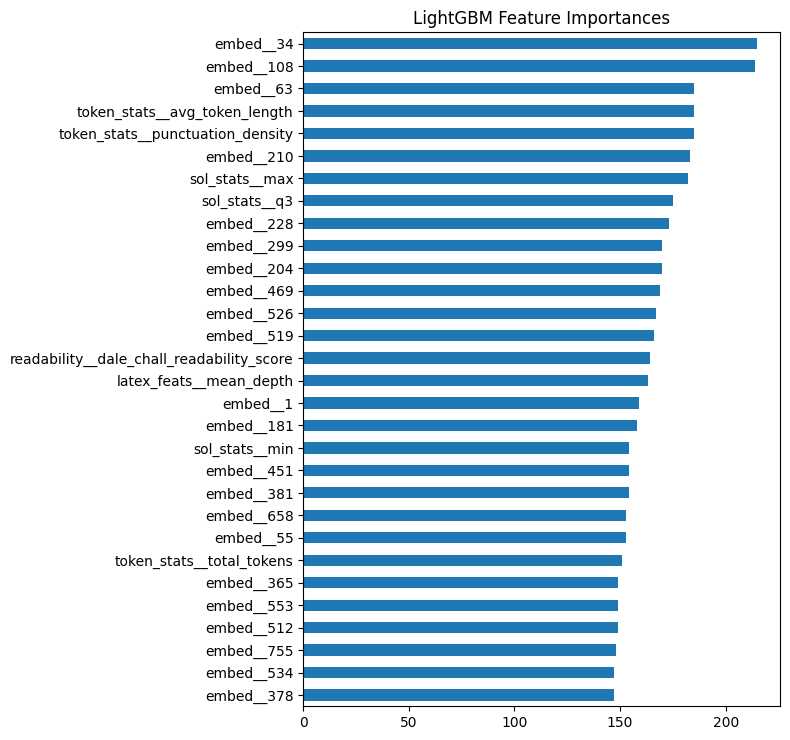

In [ ]:
importances=pipeline.named_steps["regressor"].feature_importances_
fi = pd.Series(importances, index=feat_names)


top_n = 30
top = fi.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(8, top_n*0.25))
top[::-1].plot.barh()
plt.title("LightGBM Feature Importances")
plt.tight_layout()
plt.show()

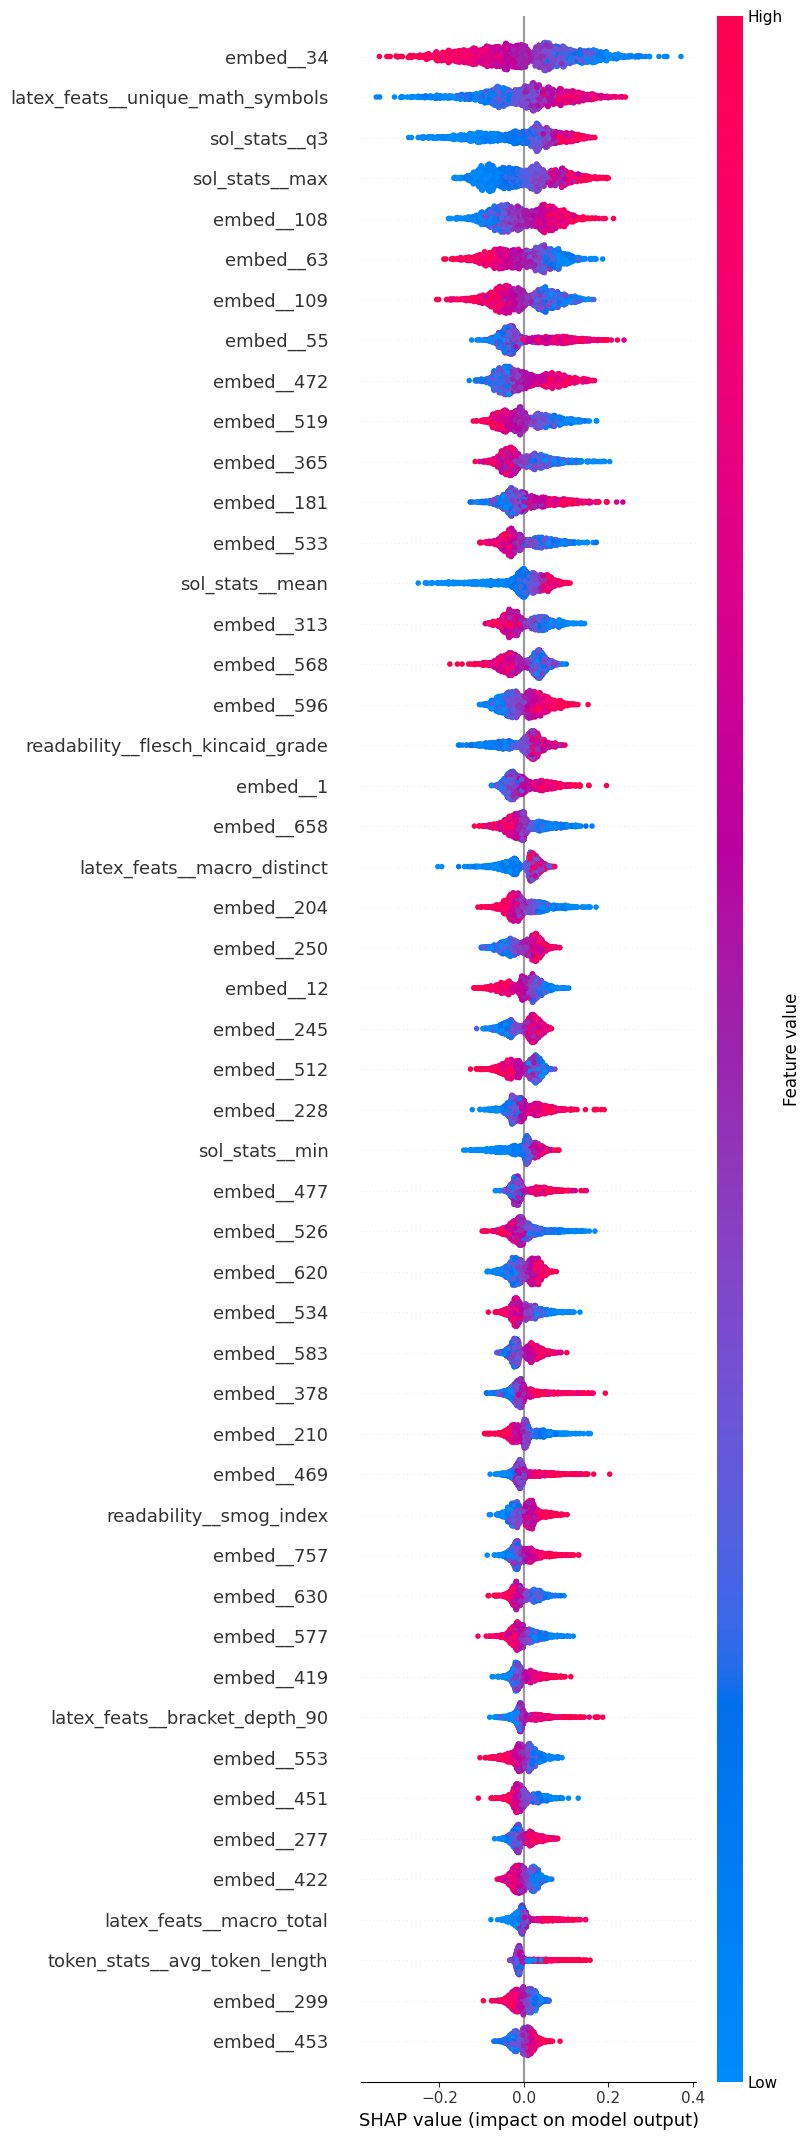

In [ ]:

lgbm = pipeline.named_steps["regressor"]
pre  = pipeline.named_steps["features"]


X_bg = X_train_reg.sample(8000, random_state=0)
X_bg_trans = pre.transform(X_bg)

if spa.issparse(X_bg_trans):
    X_for_shap = X_bg_trans.toarray()
else:
    X_for_shap = X_bg_trans

explainer = shap.TreeExplainer(lgbm)


X_ex = X_test_reg.sample(2000, random_state=1)
X_ex_trans = pre.transform(X_ex)
if spa.issparse(X_ex_trans):
    X_for_shap_test = X_ex_trans.toarray()
else:
    X_for_shap_test = X_ex_trans
shap_values = explainer.shap_values(X_for_shap_test)

shap.summary_plot(
    shap_values,
    X_for_shap_test,
    feature_names=feat_names,
    max_display=50,
)

**Feature Importance vs. SHAP Insights**

- **Embeddings lead the pack.**  
  Both LightGBM’s built-in gains and the SHAP summary agree that a small handful of SBERT embedding dimensions (e.g. `embed__34`, `embed__108`, `embed__63`) drive most of the predictive power.  

- **Solution-length stats are very strong.**  
  The max, mean and 75 th percentile of our R1/R2/R3 “solution lengths” rank near the top in both plots—confirming that longer worked‐out solutions tend to correlate with higher difficulty.  

- **Math-specific features punch above their weight.**  
  SHAP highlights `latex_feats__unique_math_symbols` as one of the very top contributors, even though its raw gain ranking was lower. This tells us symbol‐rich questions are often harder.

- **Token counts and readability are overrated.**  
  Although LightGBM sometimes splits on `total_tokens` or Flesch/Dale-Chall scores (they appear in the gain list), their overall SHAP magnitudes are small. In practice, they explain little variation once embeddings and solution stats are included.

- **Discrepancies reveal “shortcuts.”**  
  The model can leverage simple heuristics (e.g. question length) to boost gain, but SHAP shows these have inconsistent, marginal effects. Relying on them may hurt generalization.

---

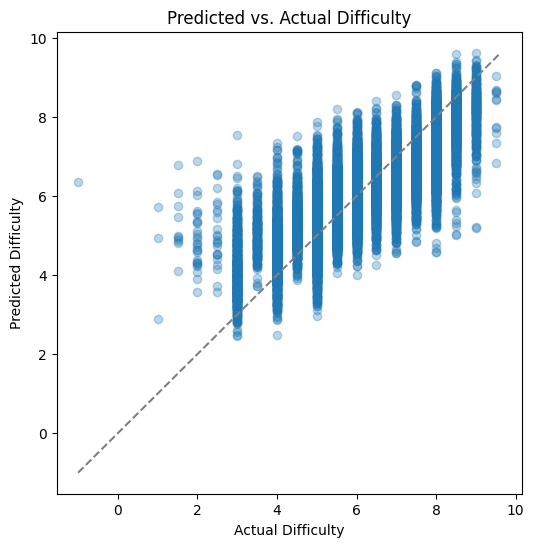

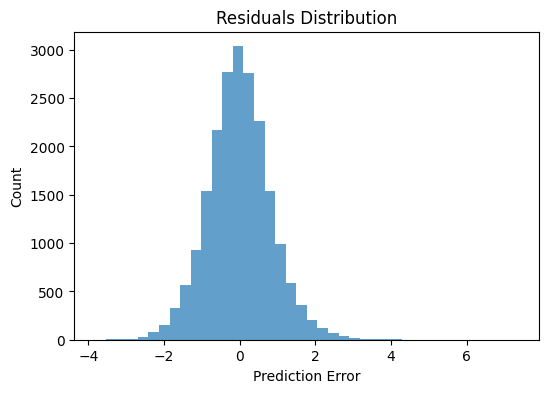

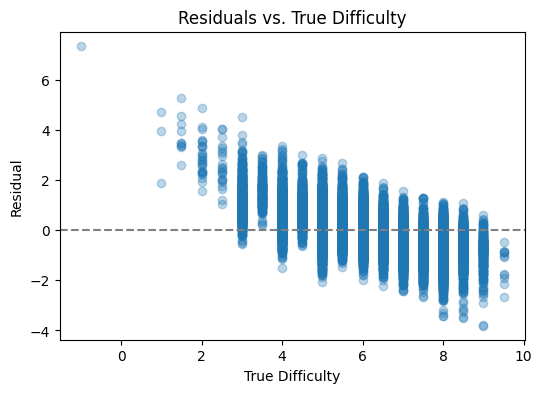

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred, alpha=0.3)
lims = [min(y_test_reg.min(), y_pred.min()), max(y_test_reg.max(), y_pred.max())]
plt.plot(lims, lims, "--", color="gray")
plt.xlabel("Actual Difficulty"); plt.ylabel("Predicted Difficulty")
plt.title("Predicted vs. Actual Difficulty")
plt.show()

y_true=y_test_reg
plt.figure(figsize=(6,4))
plt.hist((y_pred - y_true), bins=40, alpha=0.7)
plt.title("Residuals Distribution"); plt.xlabel("Prediction Error"); plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_true, (y_pred - y_true), alpha=0.3)
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("True Difficulty"); plt.ylabel("Residual")
plt.title("Residuals vs. True Difficulty")
plt.show()


**Predicted vs. Actual Difficulty**  
- The points cluster tightly along the 45° reference line, showing the model captures the overall trend well.  
- Most predictions fall within ±1 of the true label, indicating good mean accuracy.  
- We can see “bands” at integer difficulty levels (a side‐effect of training on discrete labels).  
- There’s a slight bias: at the low end (actual < 3) the model tends to overestimate, and at the high end (>8) it tends to underestimate.  

**Residuals Distribution**  
- The residuals form an approximately symmetric, bell‐shaped histogram centered near zero—evidence that the errors are unbiased on average.  
- The tails extend out to ±4, signaling occasional large miss‐predictions (possible outliers or rare question types).  
- A slight skew toward positive residuals suggests a mild tendency to over-predict, especially on easier questions.  

**Residuals vs. True Difficulty**  
- In the mid‐range difficulties (≈4–6), residuals are tightly packed around zero, showing high precision on the bulk of the data.  
- There’s a clear heteroscedastic pattern: positive residuals (over-predictions) for low‐difficulty questions and negative residuals (under-predictions) for high‐difficulty ones.  
- This “compression” means the model’s slope is too shallow—it doesn’t fully stretch out the extremes.  


## M1S: Base model (short answer)

## M2: Introduce reasoning

## Comparisons